In [2]:
import numpy as np

from scipy.cluster import hierarchy as hac
from sklearn import preprocessing as ppr

import matplotlib.pyplot as plt
import pickle

In [3]:
def tfidf(count_matrix):
    ''' Takes as input a count matrix 
        of term occurencies in documents
        'doc-term' (N_doc x N_term)
        and returns a tfidf matrix of 
        same dimensions'''
    
    [total_number_of_documents, total_number_of_terms] = count_matrix.shape
            
    tf = count_matrix
    
    documents_containing_the_word = np.count_nonzero(count_matrix, axis = 0)

    df = (documents_containing_the_word + 1)/(total_number_of_documents +1)
    idf = np.log(np.reciprocal(df)) + 1
    
    tf_idf = np.zeros([total_number_of_documents, total_number_of_terms])

    for i in range(total_number_of_documents):
        tf_idf[i,:] = tf[i,:]*idf
    
    tf_idf = ppr.normalize(tf_idf, norm='l2')
    return(tf_idf)

In [4]:
with open('data.train', 'r', 10000) as t:
    lines = t.read().splitlines()
    
print('Comments:')
print(len(lines))

voc_dict = {}
voc_dict_inv = {}
i = 0
with open('vocab.bpe.from','r') as f:
    keys = f.read().splitlines()
    for key in keys:
        if i>2 :
            voc_dict[i-3] = key
            voc_dict_inv[key] = i-3            
#             print(key)
        i+=1
print('\nVocabulary size:')
print(i)

with open('subreddits.train','r') as l:
    ls = l.read().splitlines()
    label_names = list(set(ls))
        
# print(label_names)

labels_dict = {}
labels_dict_inv = {}
for i, label_name in enumerate(label_names):
    labels_dict[i] = label_name
    labels_dict_inv[label_name] = i

print('\nLabels dictionary size:')
print(len(labels_dict))
# print(labels_dict_inv)

subredditsXvocwords = np.zeros([len(labels_dict), 15000])

for i, (comment, label) in enumerate(zip(lines,ls)):
    words = comment.split(' ')
    for w in words:
        subredditsXvocwords[labels_dict_inv[label], voc_dict_inv[w]] += 1

del(lines)
del(ls)

Comments:
15239328

Vocabulary size:
15003

Labels dictionary size:
1342


In [5]:
stop_words = 0
for i in range(15000):
#     print(np.count_nonzero(count_matrix[:,i]))
    if np.count_nonzero(subredditsXvocwords[:,i])/1342 >= 0.8 :
#         print(voc_dict[i])
        stop_words+=1

In [6]:
stop_words

3591

In [7]:
small_keys=[]
voc_dict_clean={}
voc_dict_inv_clean={}
count_matrix_small = np.zeros([1342,15000-stop_words])

counter = 0
non_stop_words = 0
for i in range(15000):
#     print(np.count_nonzero(count_matrix[:,i]))
    if  np.count_nonzero(subredditsXvocwords[:,i])/1342<0.8 :
#         print(voc_dict[i])
        non_stop_words+=1
        small_keys.append(voc_dict[i])
        
        voc_dict_clean[counter]=voc_dict[i]
        voc_dict_inv_clean[voc_dict[i]]=counter
        count_matrix_small[:,counter] += subredditsXvocwords[:,i]
        counter+=1
        
        
print(non_stop_words)

11409


In [8]:
subreddit_tf_idf = tfidf(count_matrix_small)
z = hac.linkage(subreddit_tf_idf, method = 'complete', metric = 'cosine')

In [9]:
# makes list of N clusters after (1342-Ν) unions

k = np.zeros([len(labels_dict)-1, 2])
k[:,0]=z[:,0]
k[:,1]=z[:,1]
k = k.astype(int)
l = k.tolist()
m = [[] for x in range(2*len(labels_dict)-1)]
for i in range(len(labels_dict)):
    m[i].append(i)

N=40

for k in range(len(labels_dict)-N):
    for j in range(2):
        if l[k][j]<len(labels_dict):
            m[k+len(labels_dict)].append(l[k][j])
            m[l[k][j]]=[]
        else:
            for i in m[l[k][j]]:
                m[k+len(labels_dict)].append(i)
            m[l[k][j]]=[]


                                     Cluster 1

                                     Cluster 2


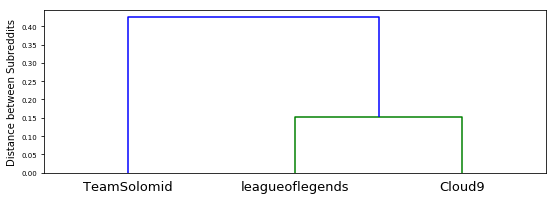


                                     Cluster 3


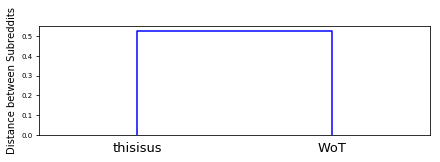


                                     Cluster 4


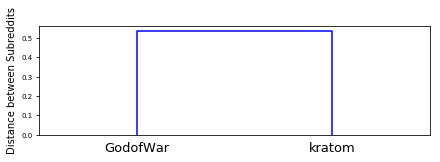


                                     Cluster 5


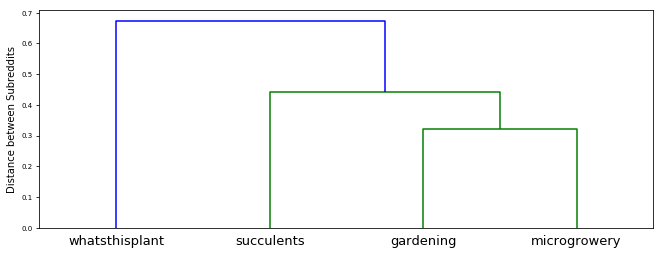


                                     Cluster 6


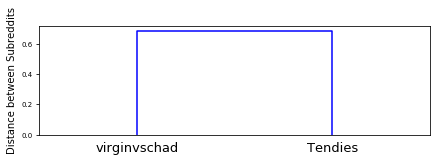


                                     Cluster 7


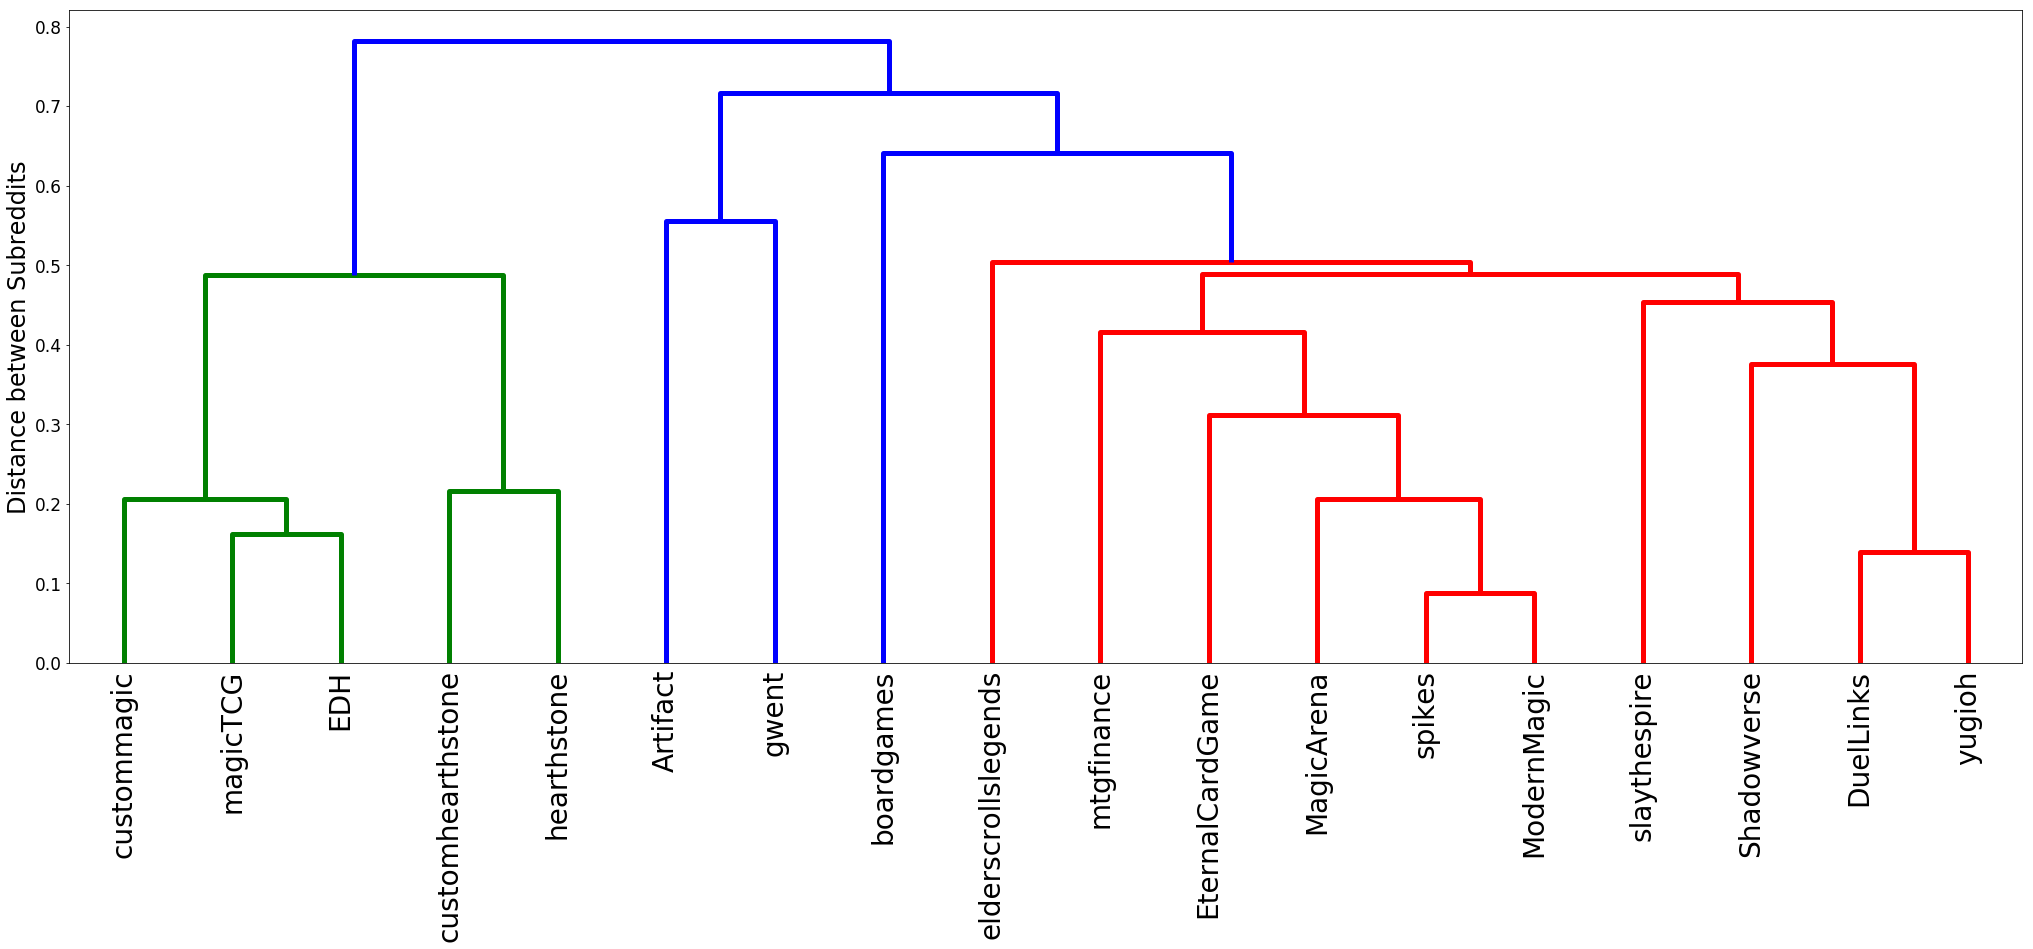


                                     Cluster 8


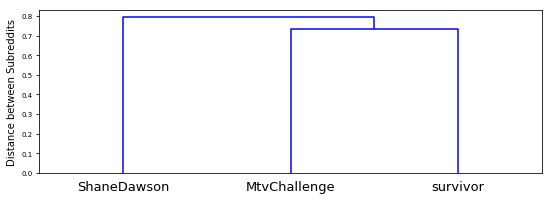


                                     Cluster 9


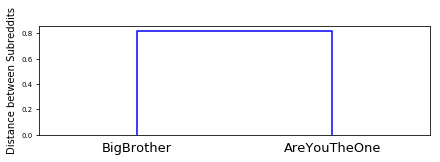


                                     Cluster 10


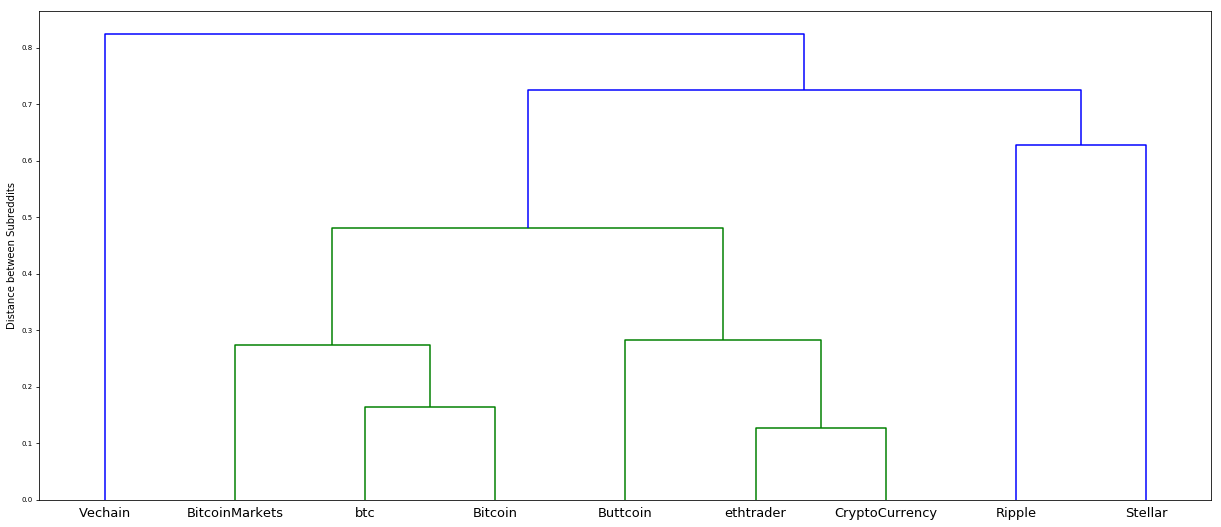


                                     Cluster 11


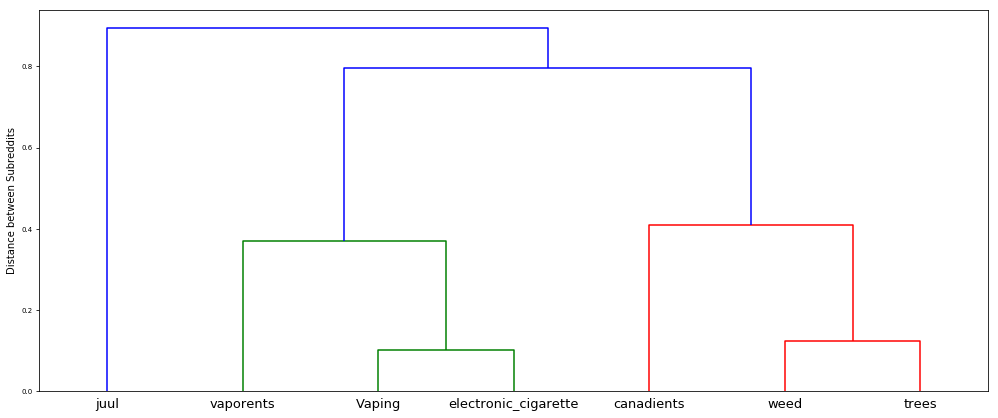


                                     Cluster 12


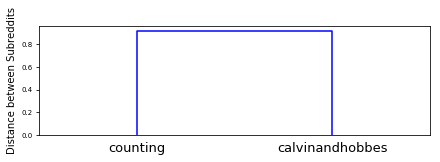


                                     Cluster 13


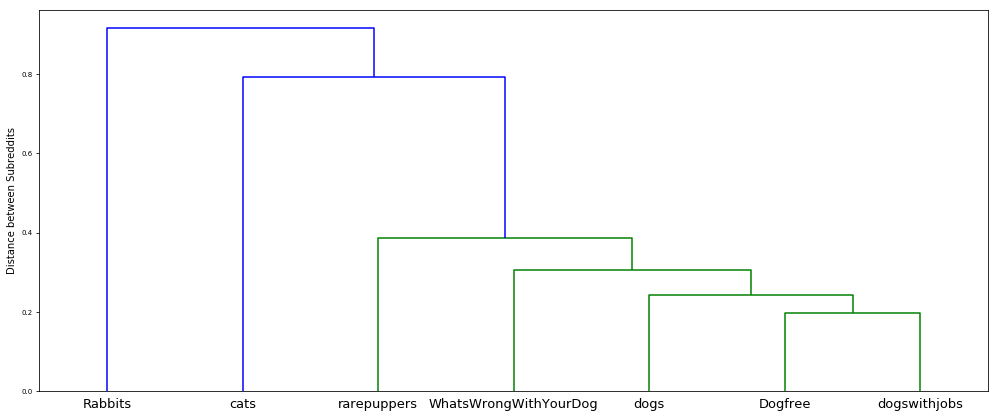


                                     Cluster 14


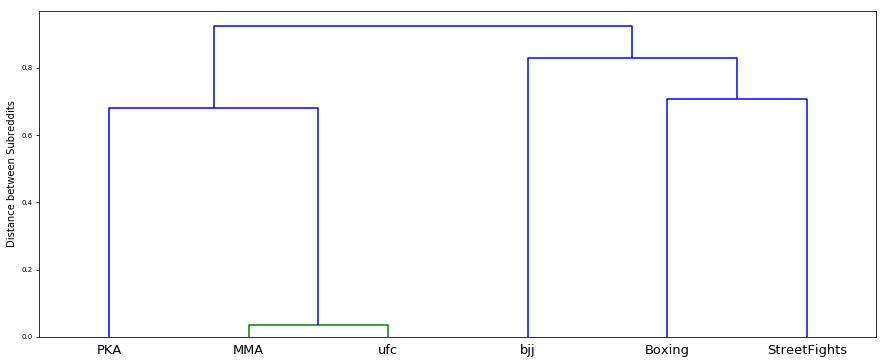


                                     Cluster 15


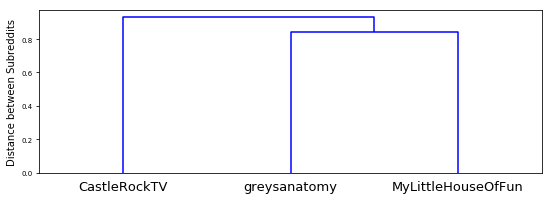


                                     Cluster 16


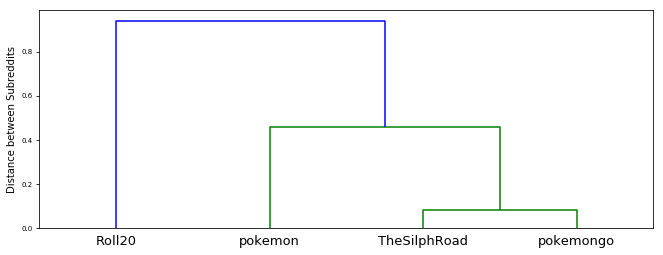


                                     Cluster 17


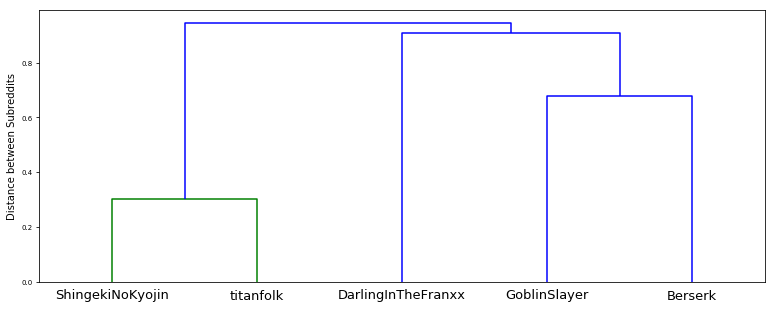


                                     Cluster 18


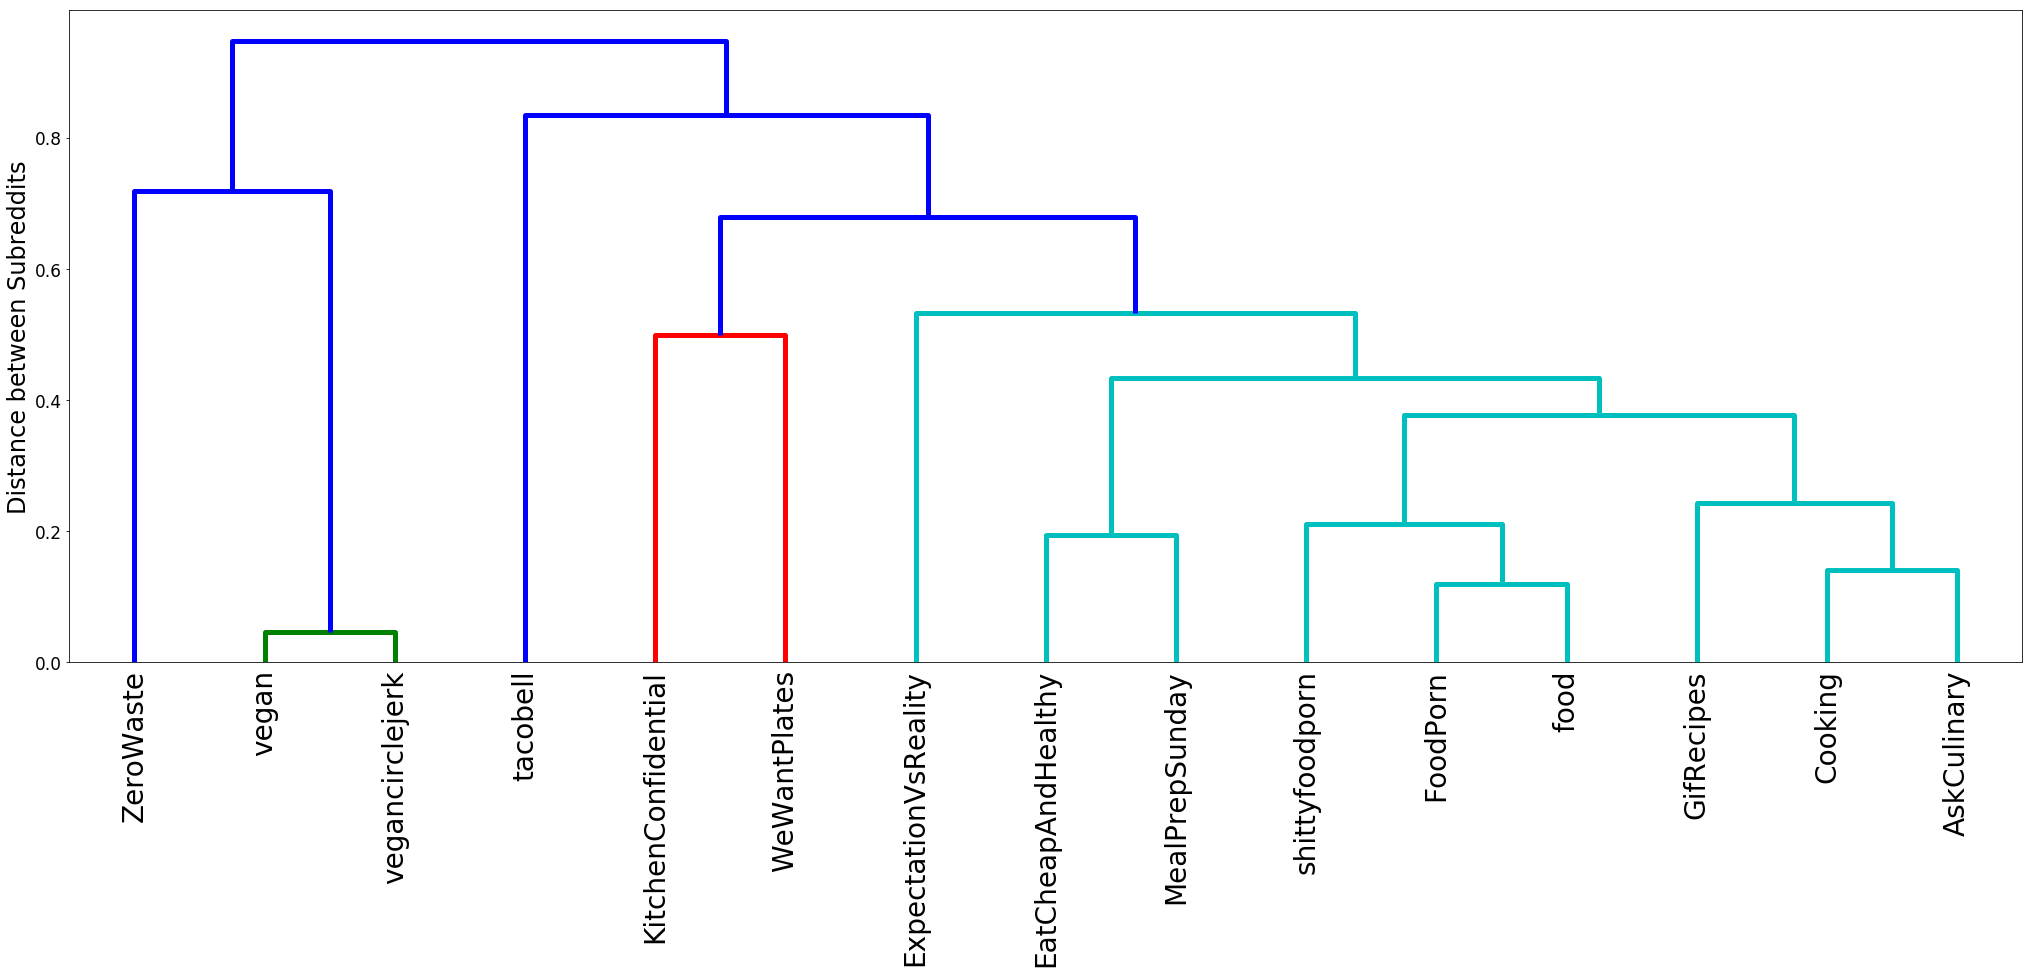


                                     Cluster 19


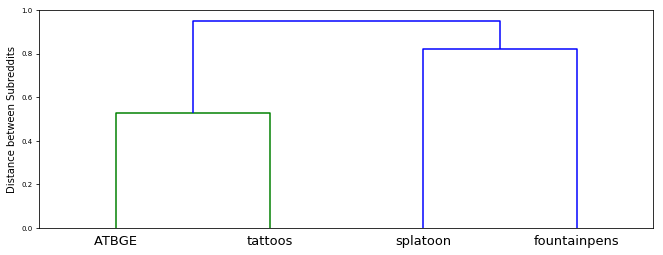


                                     Cluster 20


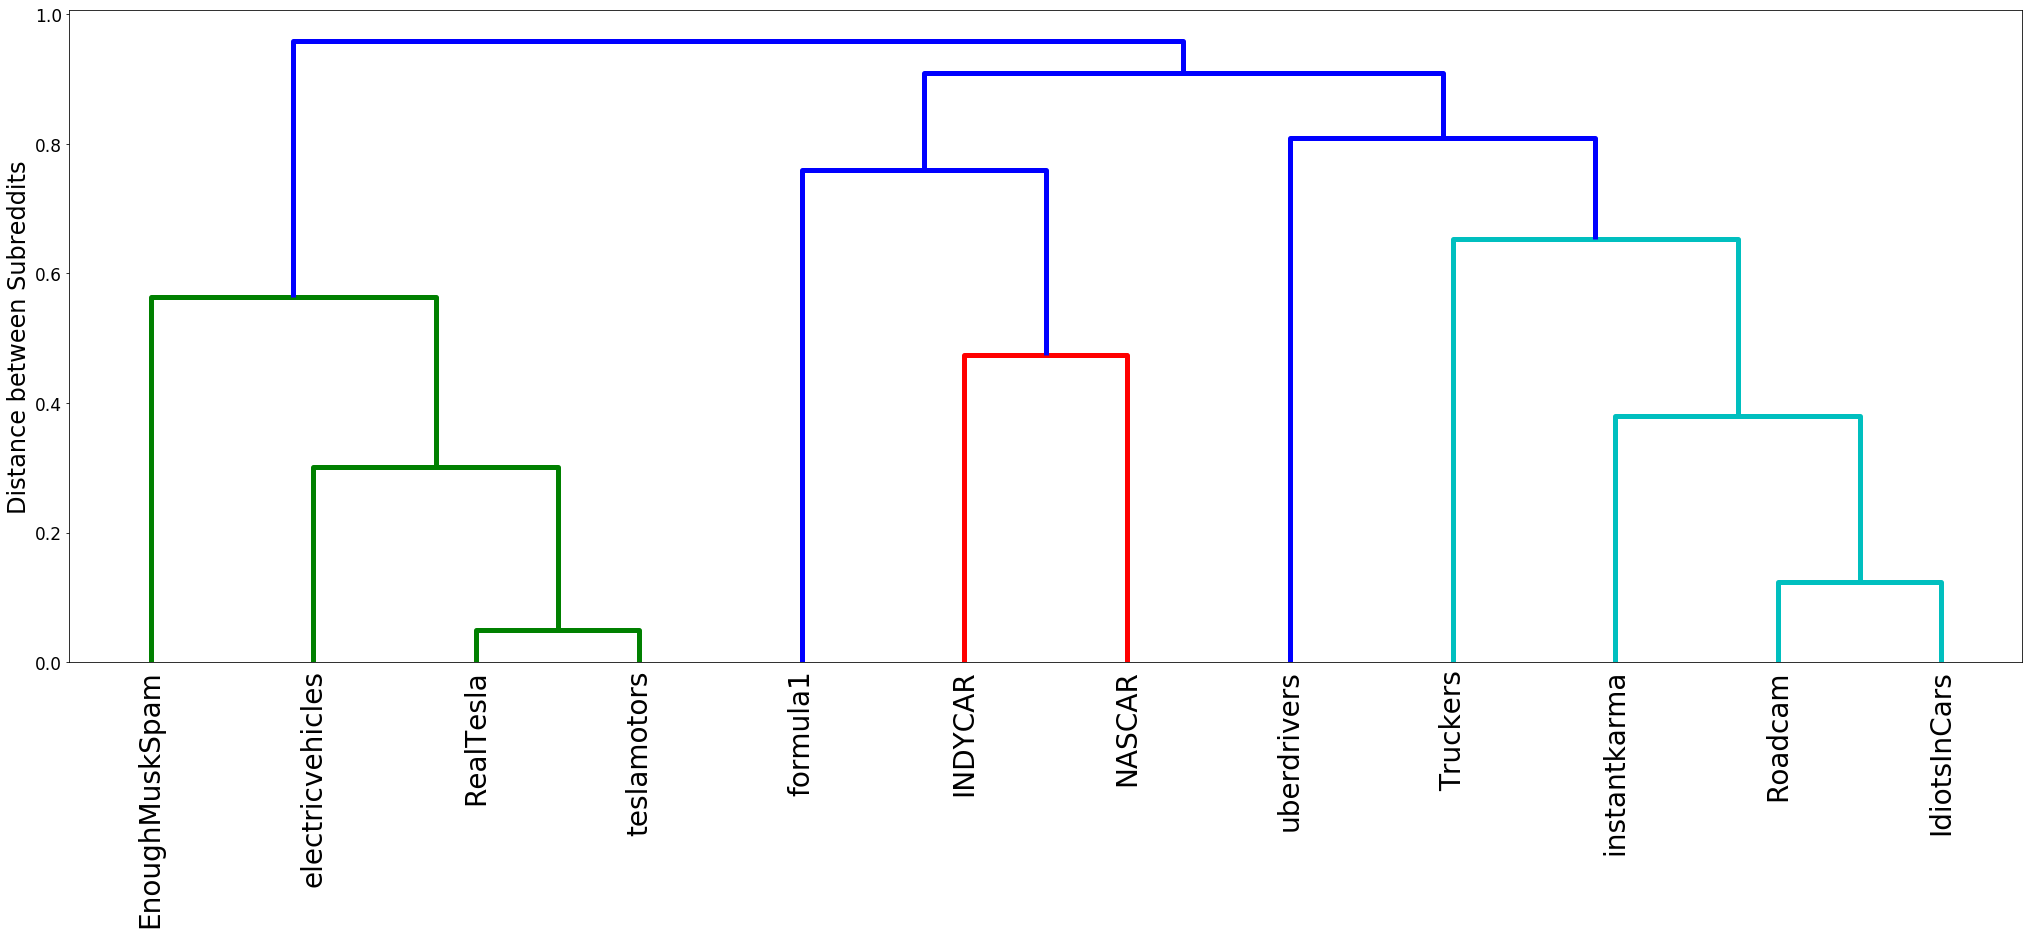


                                     Cluster 21


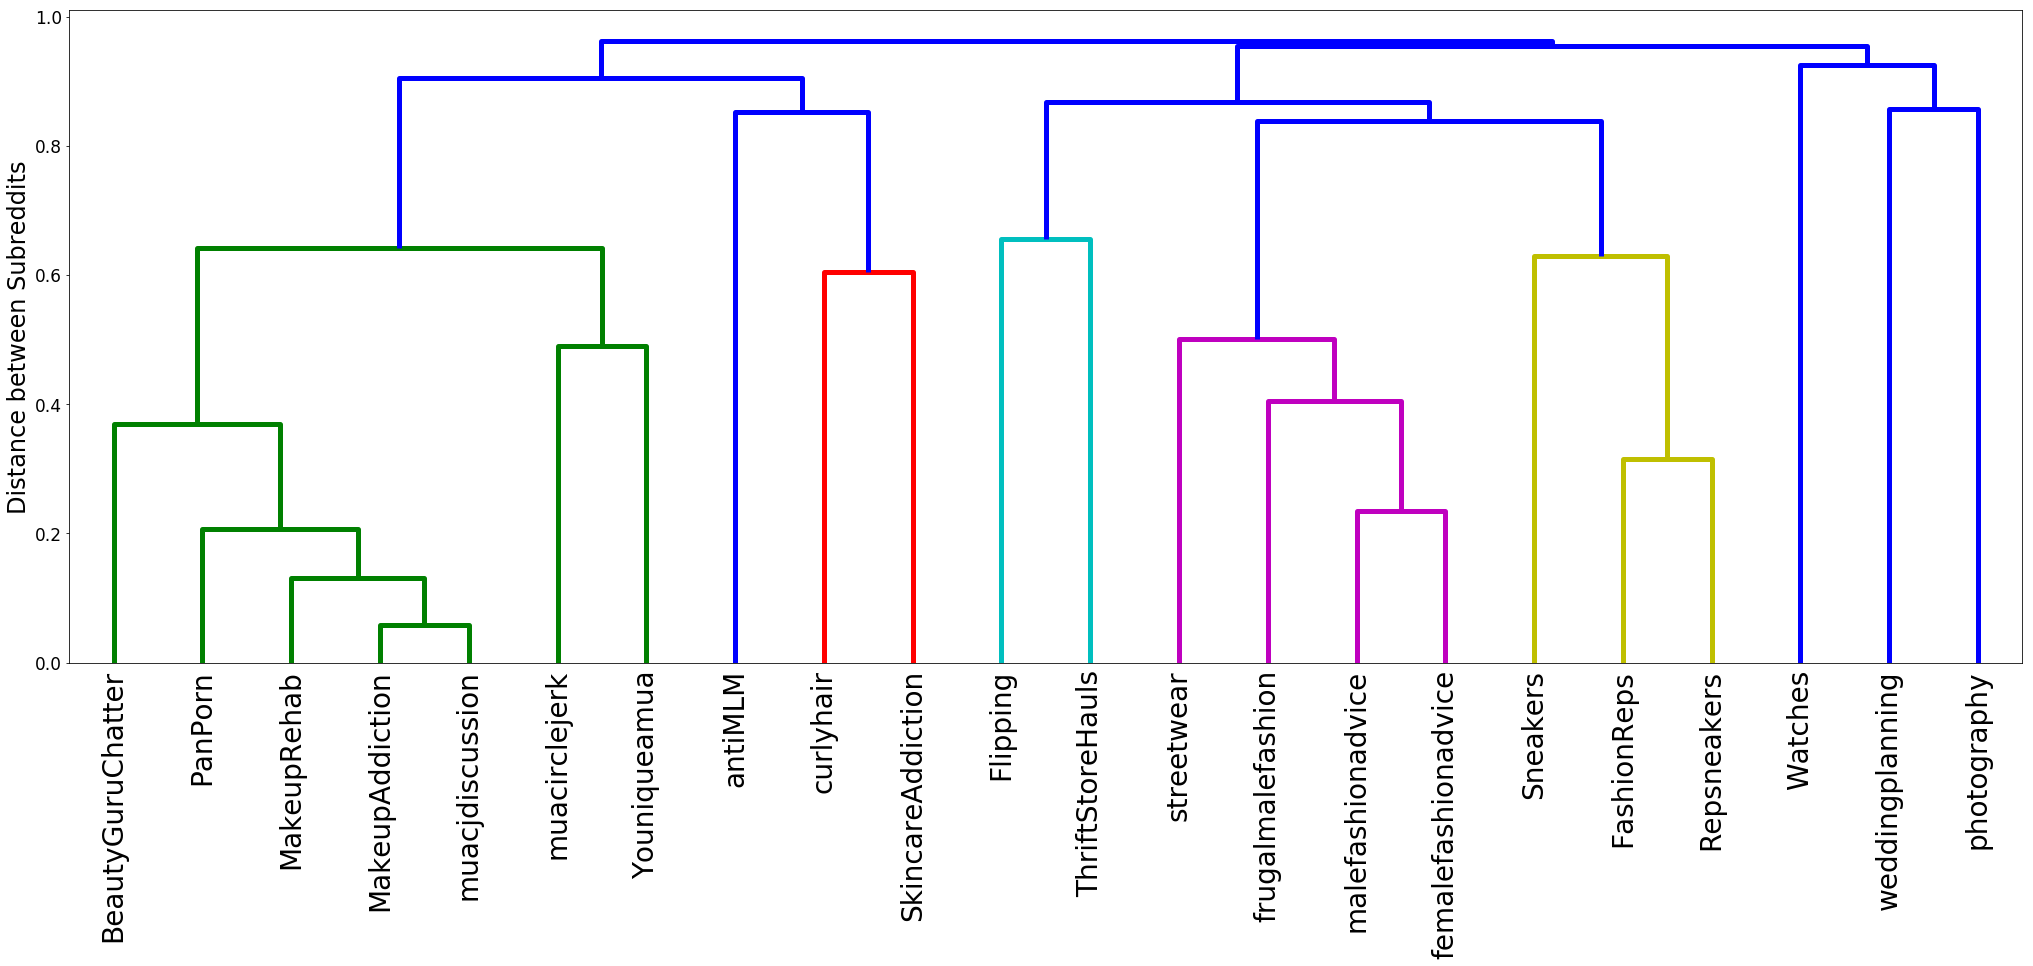


                                     Cluster 22


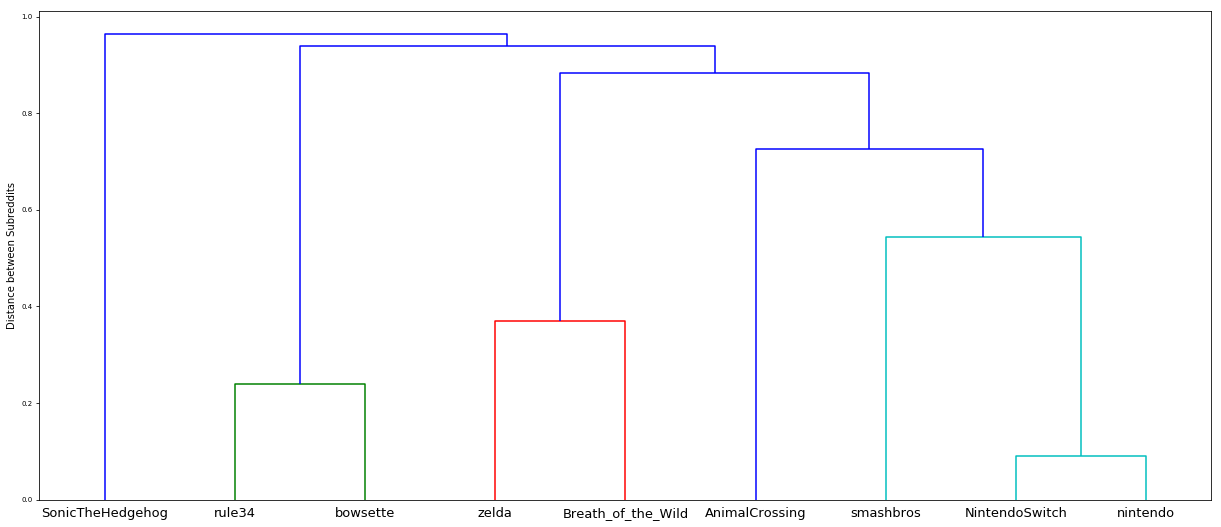


                                     Cluster 23


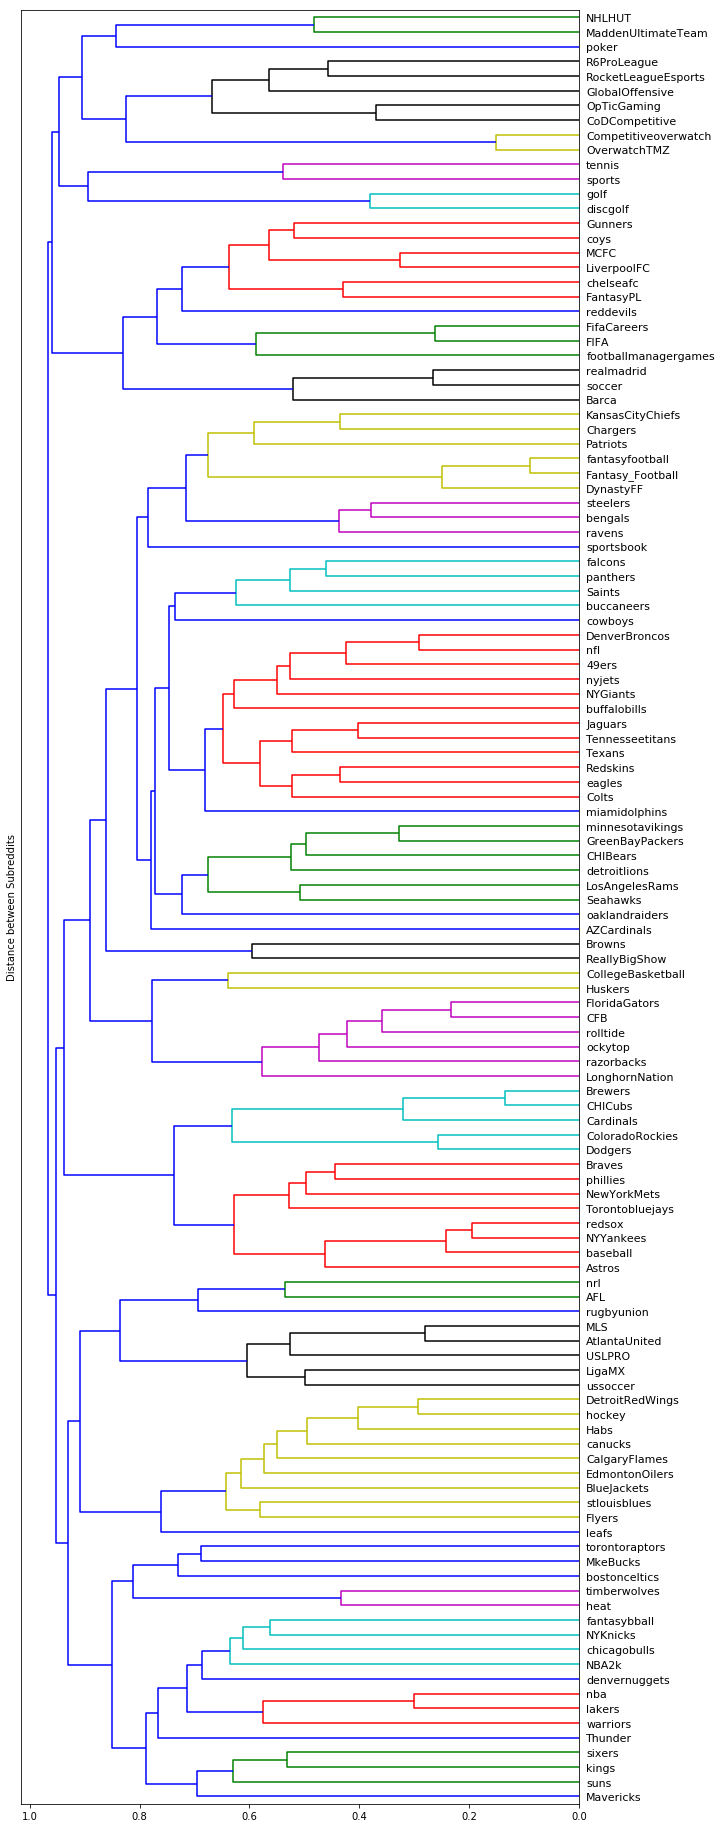


                                     Cluster 24


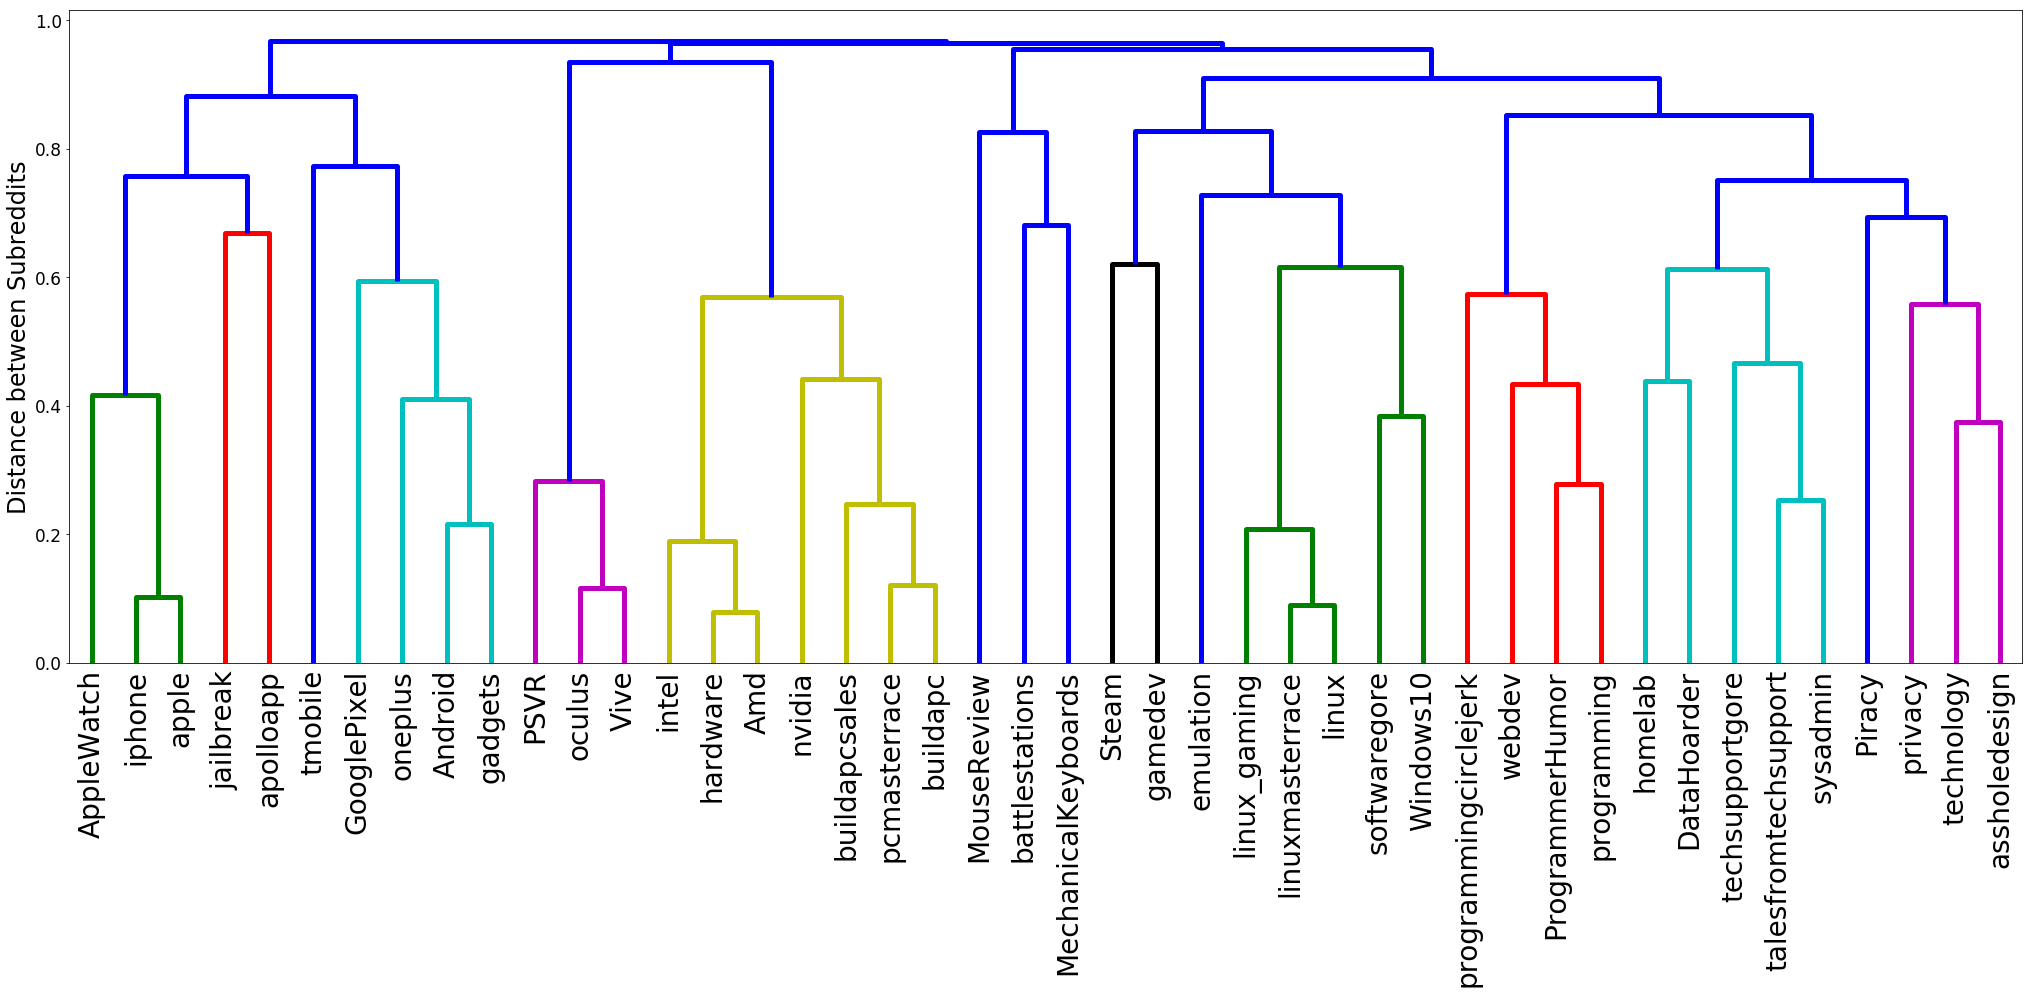


                                     Cluster 25


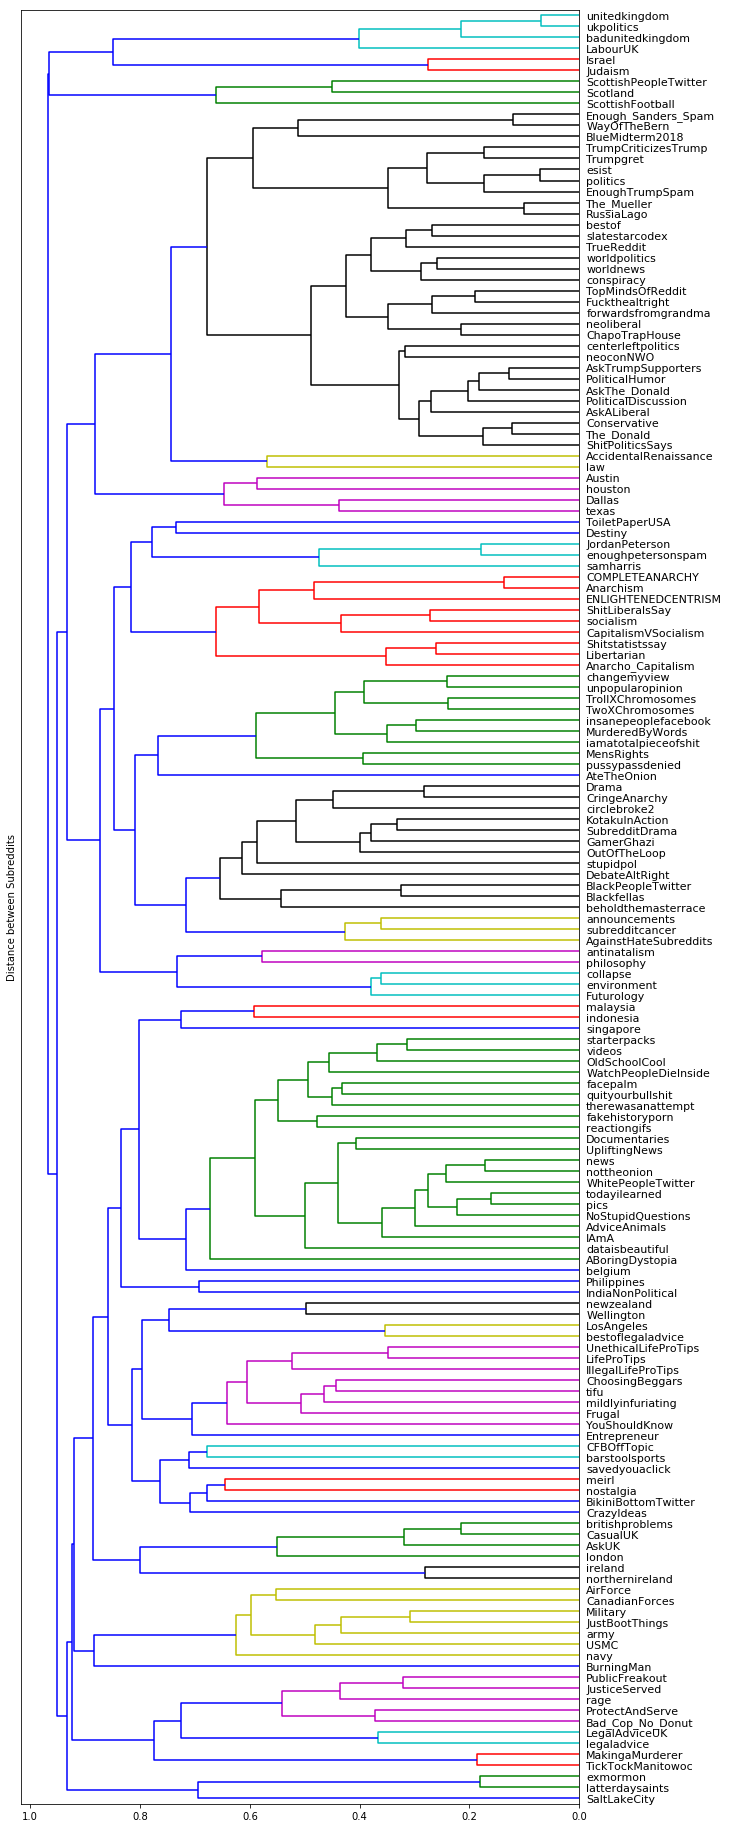


                                     Cluster 26


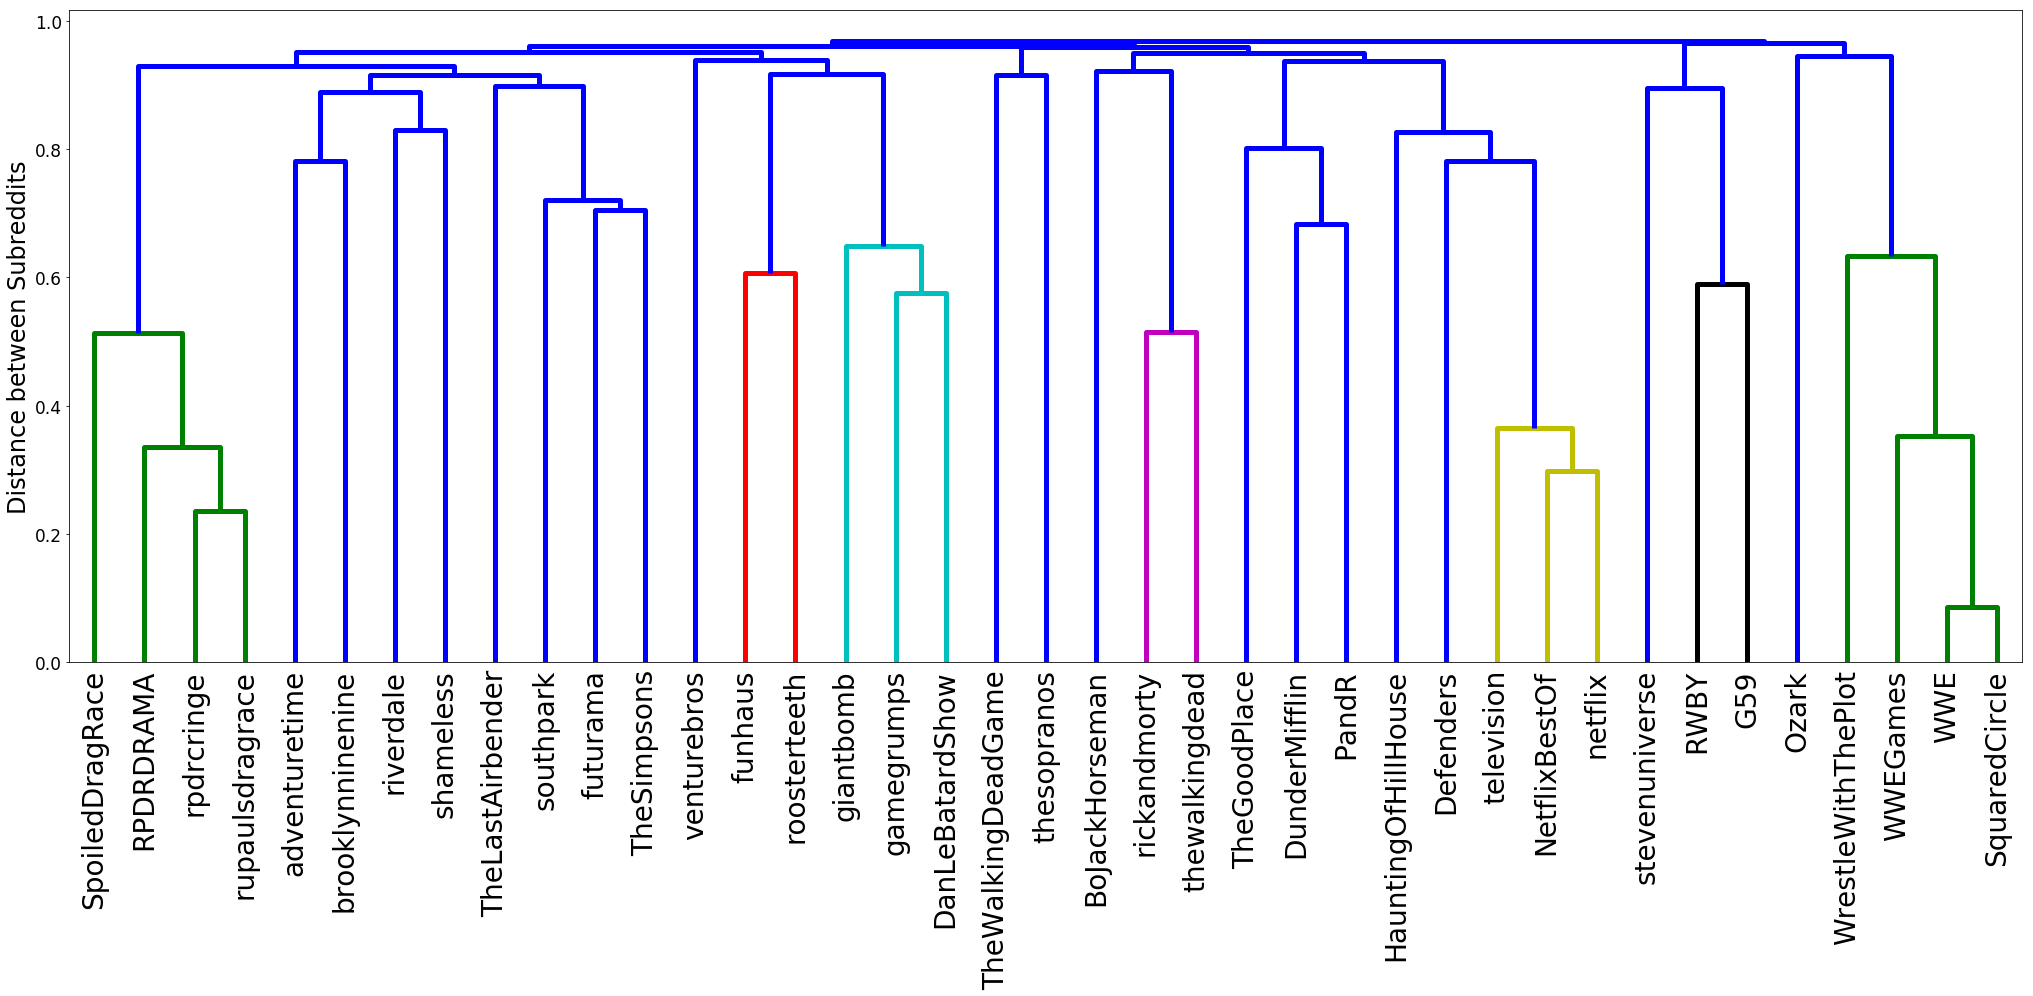


                                     Cluster 27


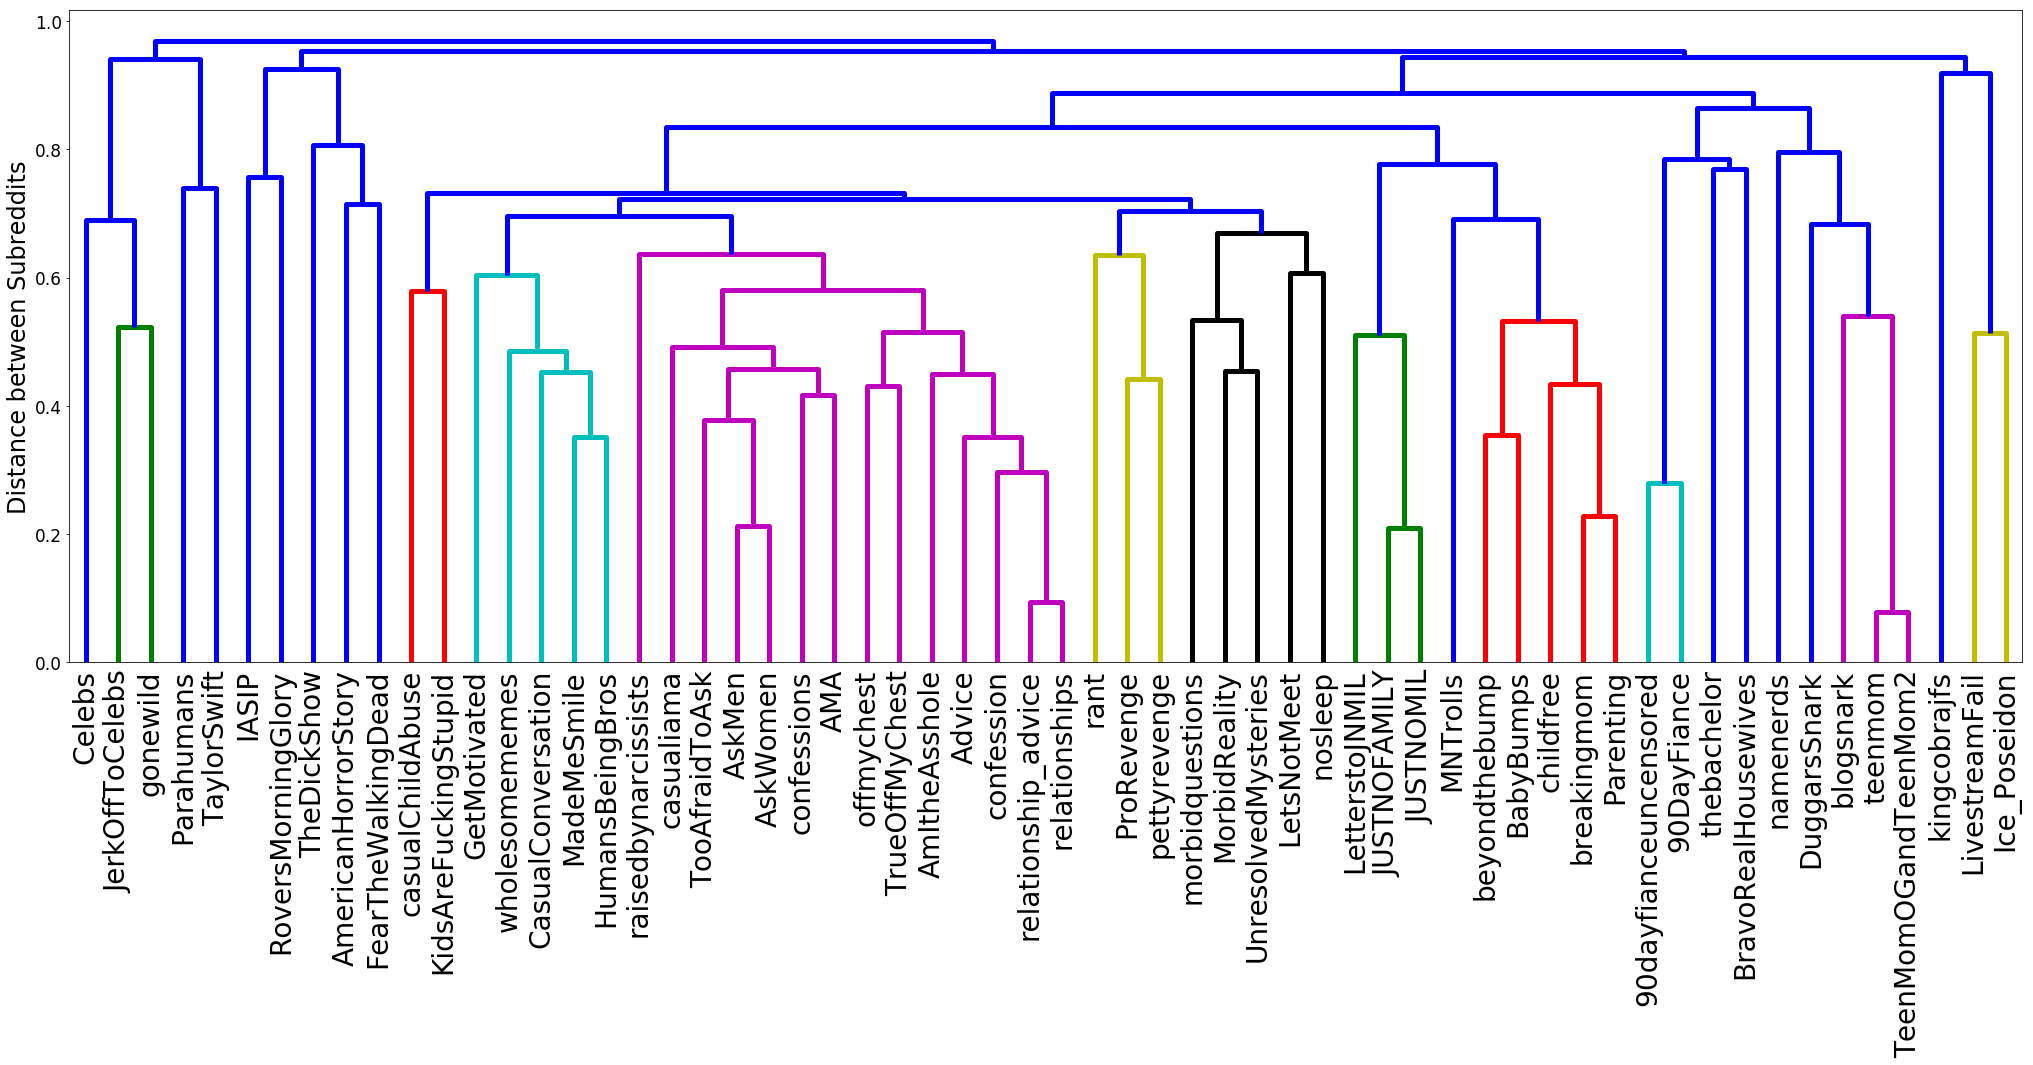


                                     Cluster 28


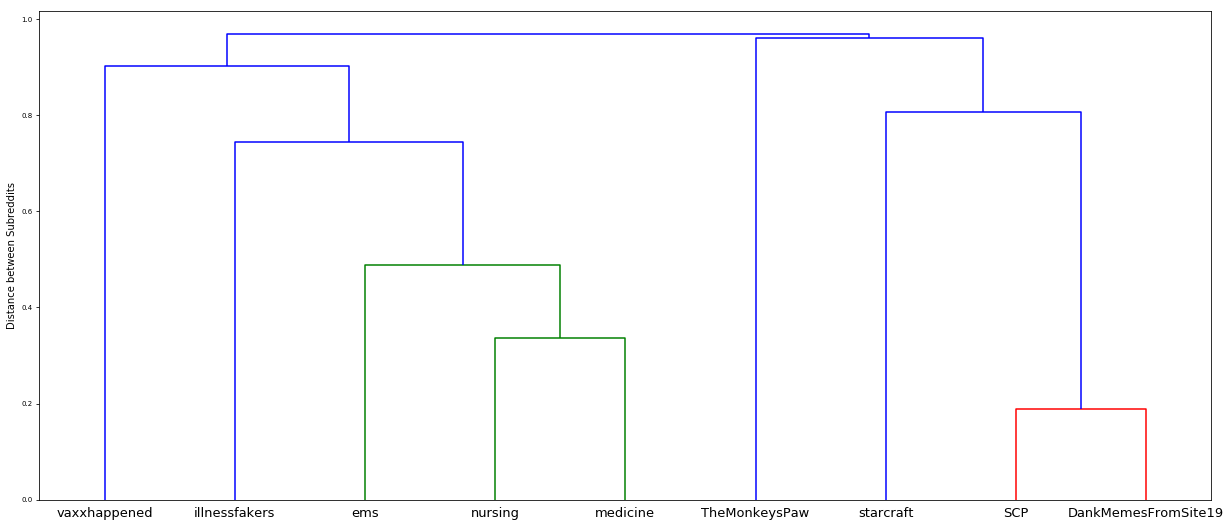


                                     Cluster 29


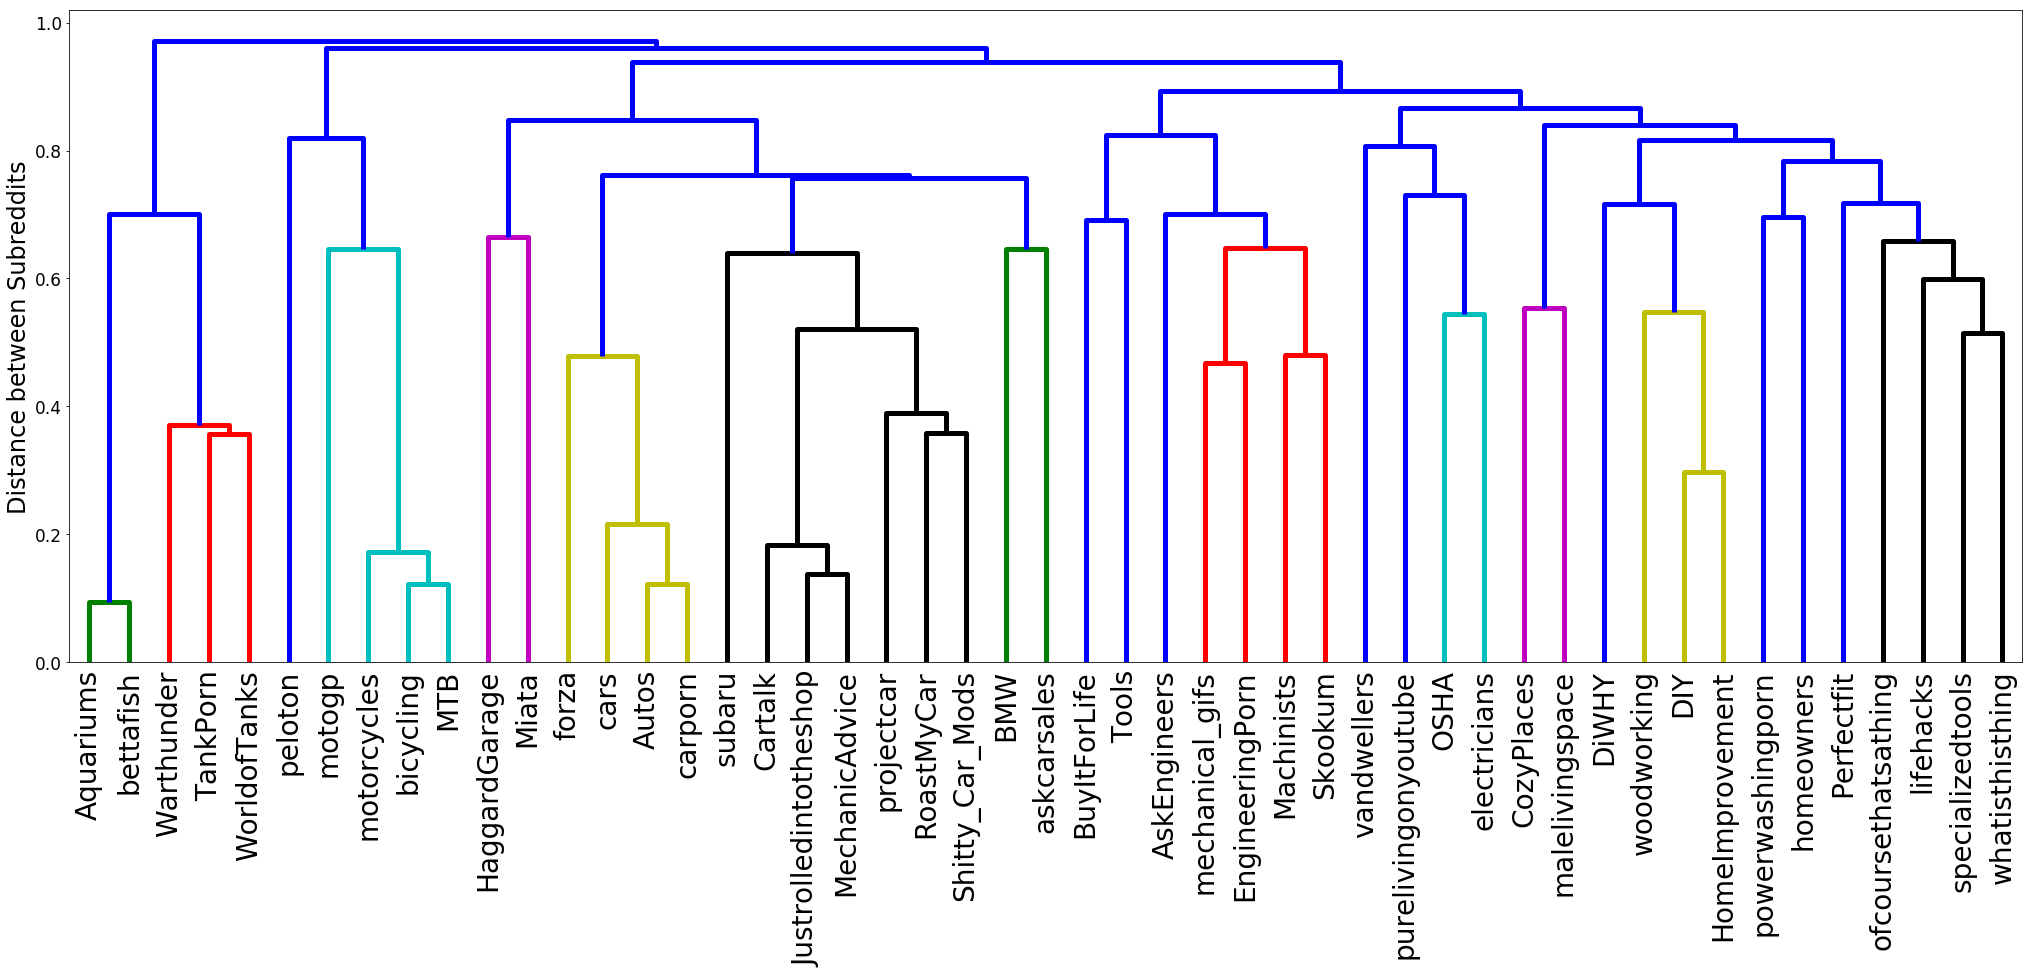


                                     Cluster 30


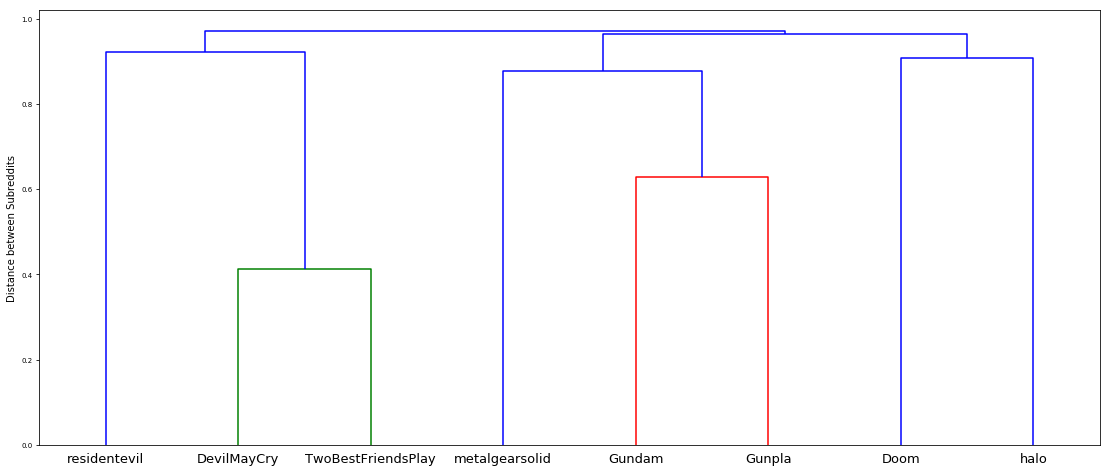


                                     Cluster 31


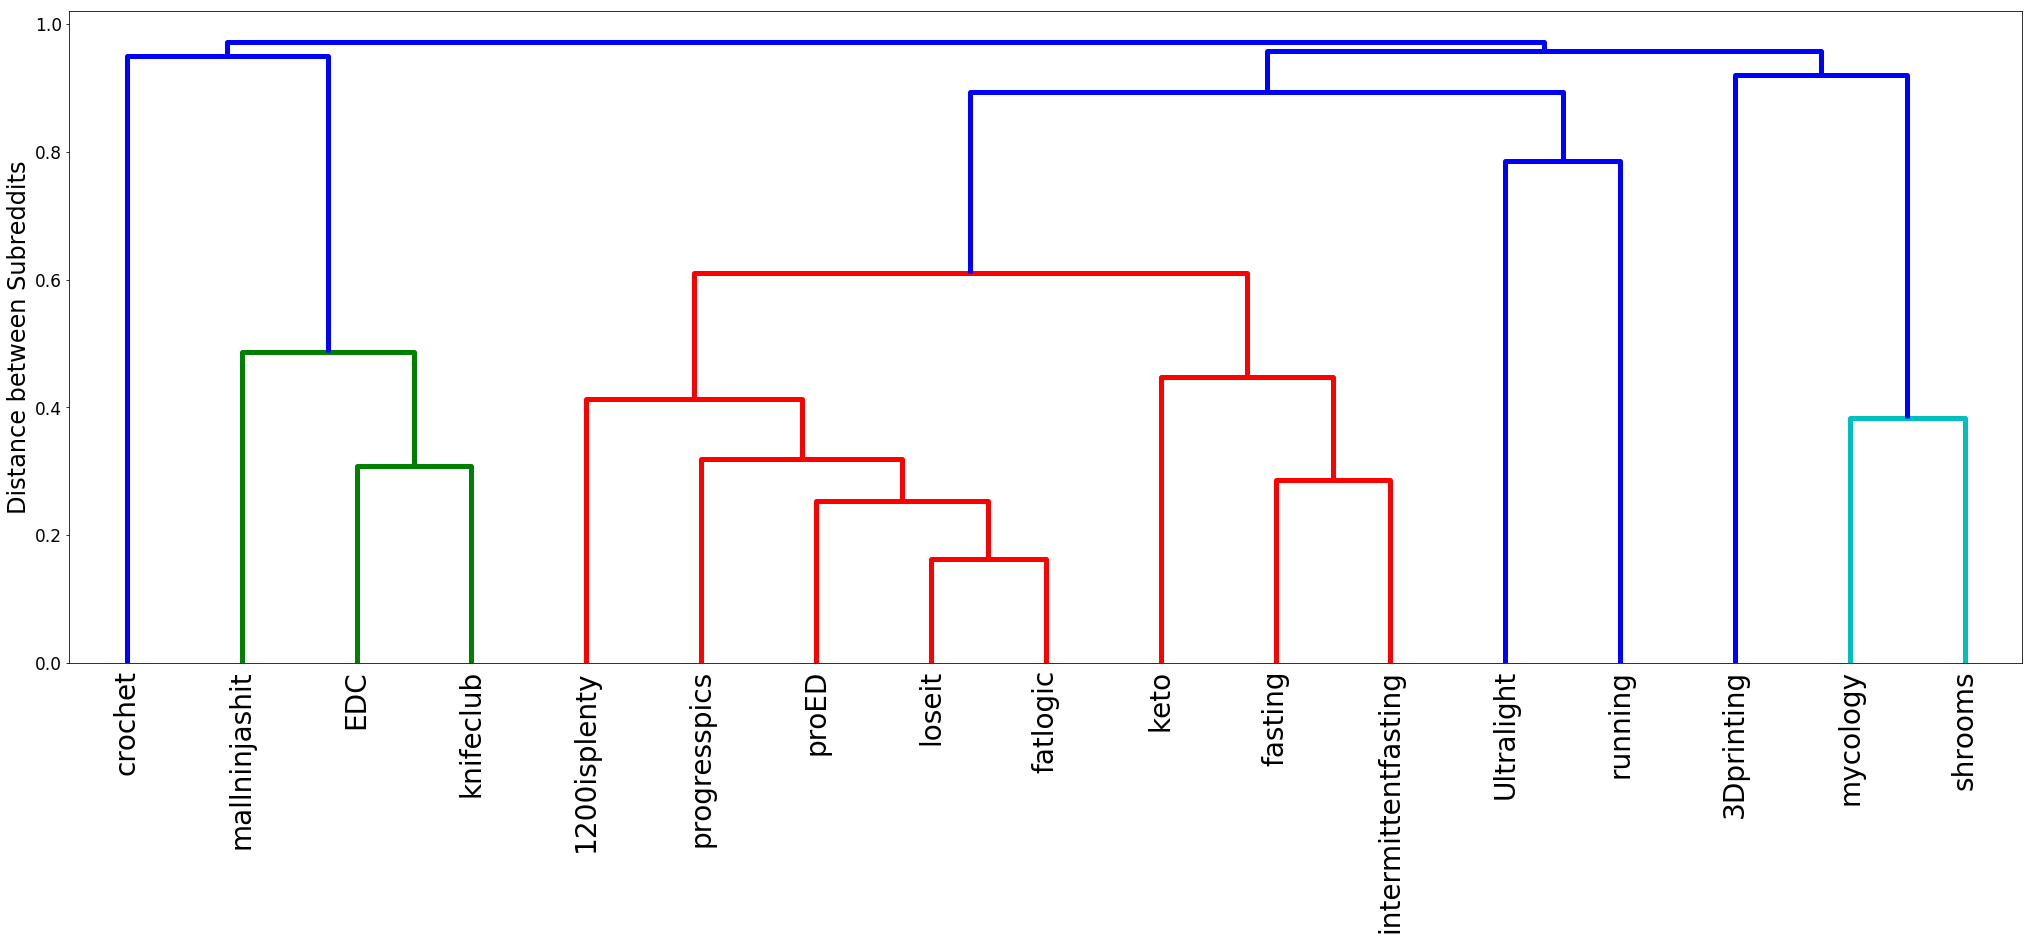


                                     Cluster 32


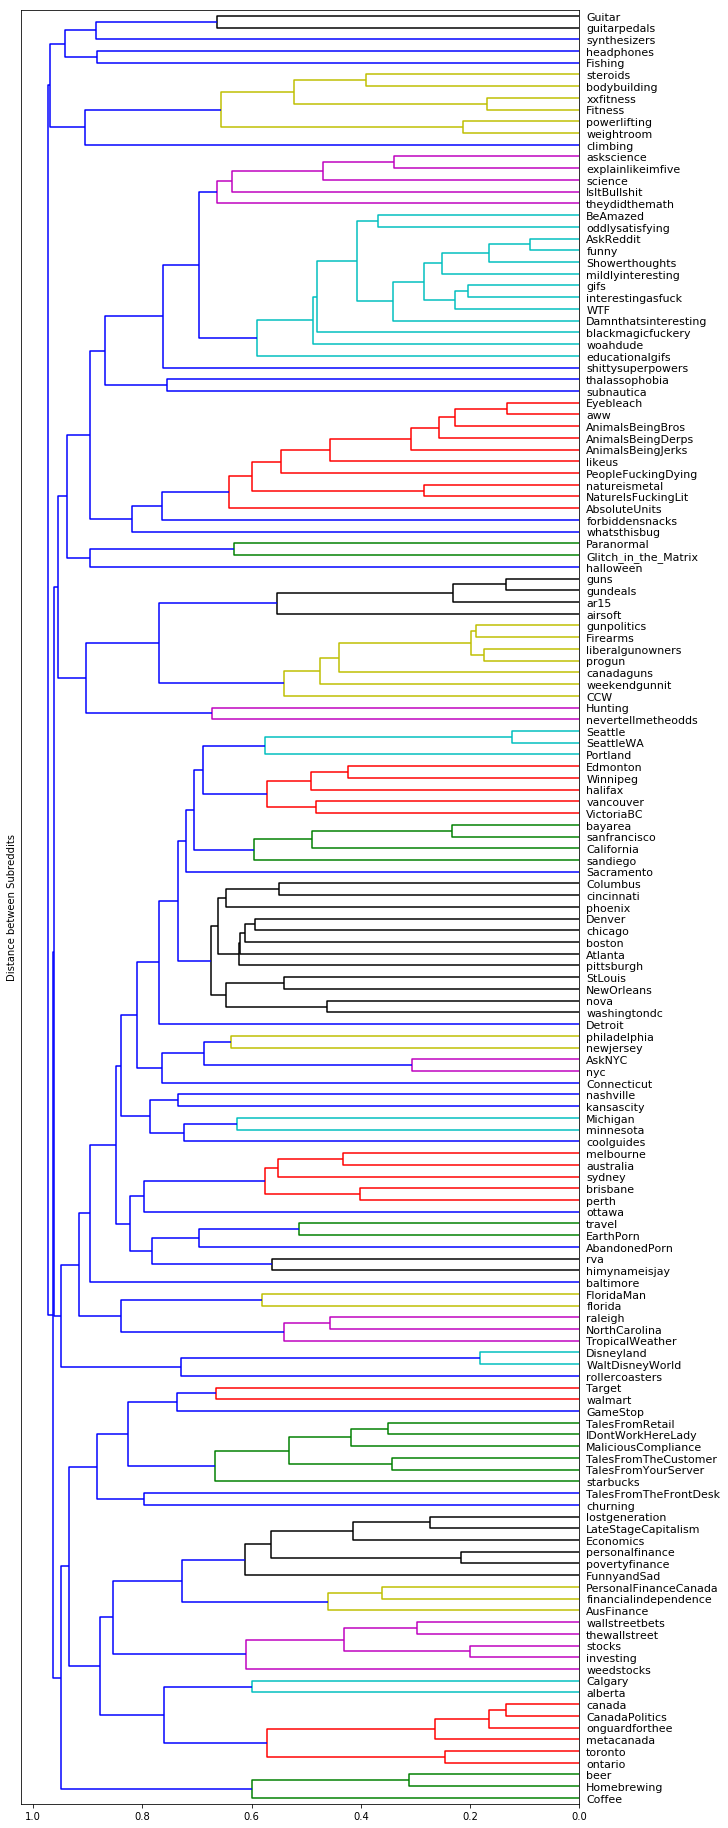


                                     Cluster 33


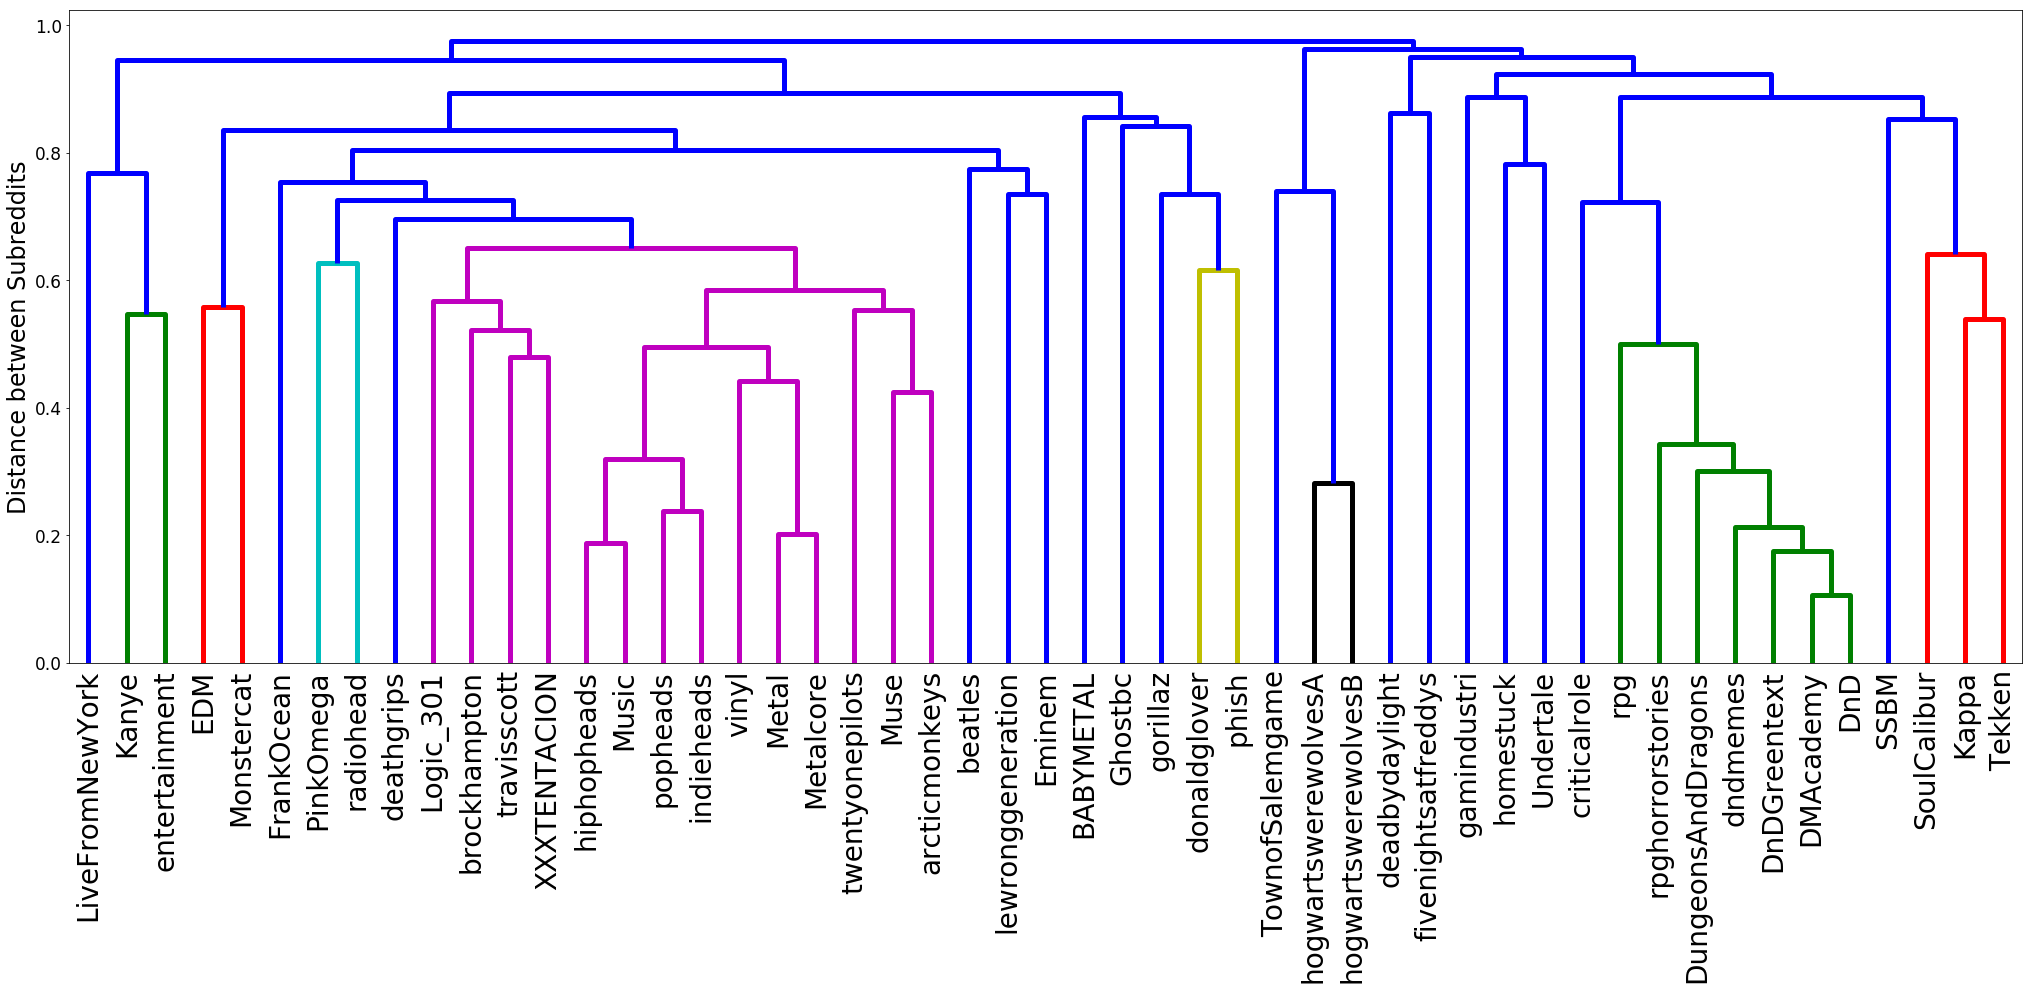


                                     Cluster 34


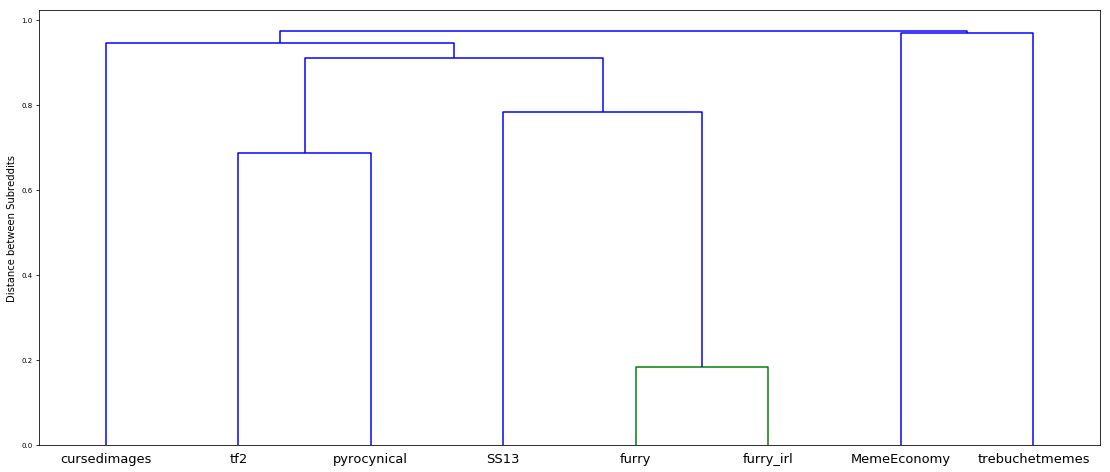


                                     Cluster 35


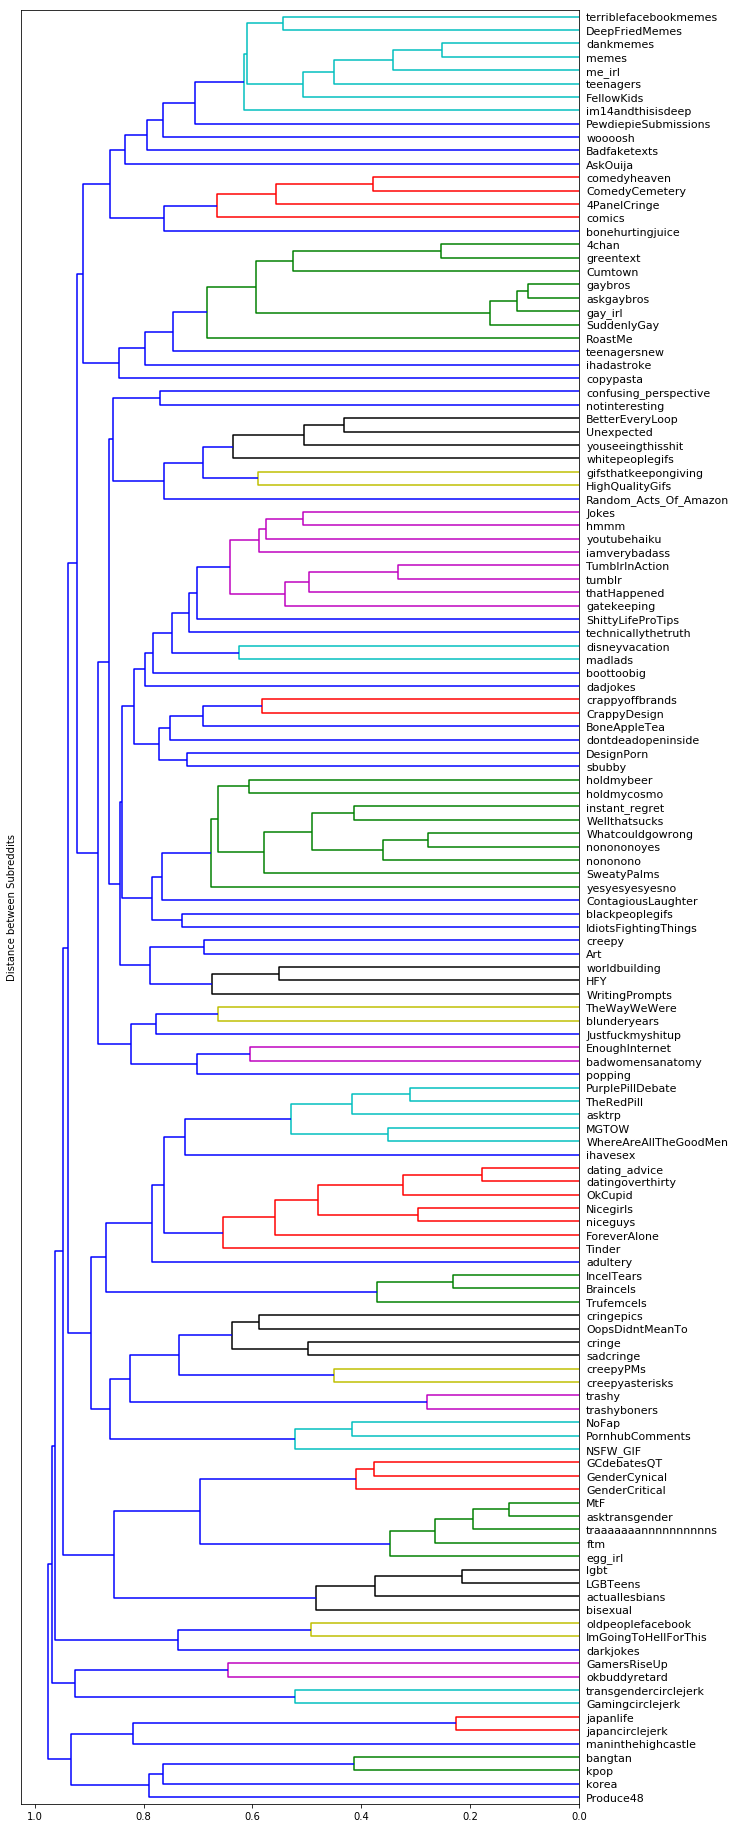


                                     Cluster 36


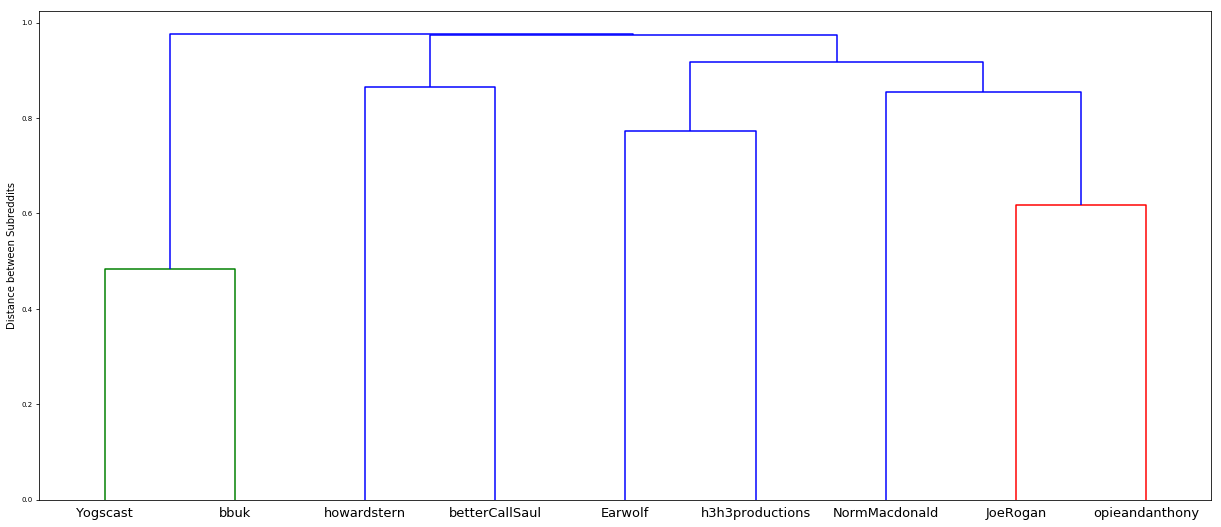


                                     Cluster 37


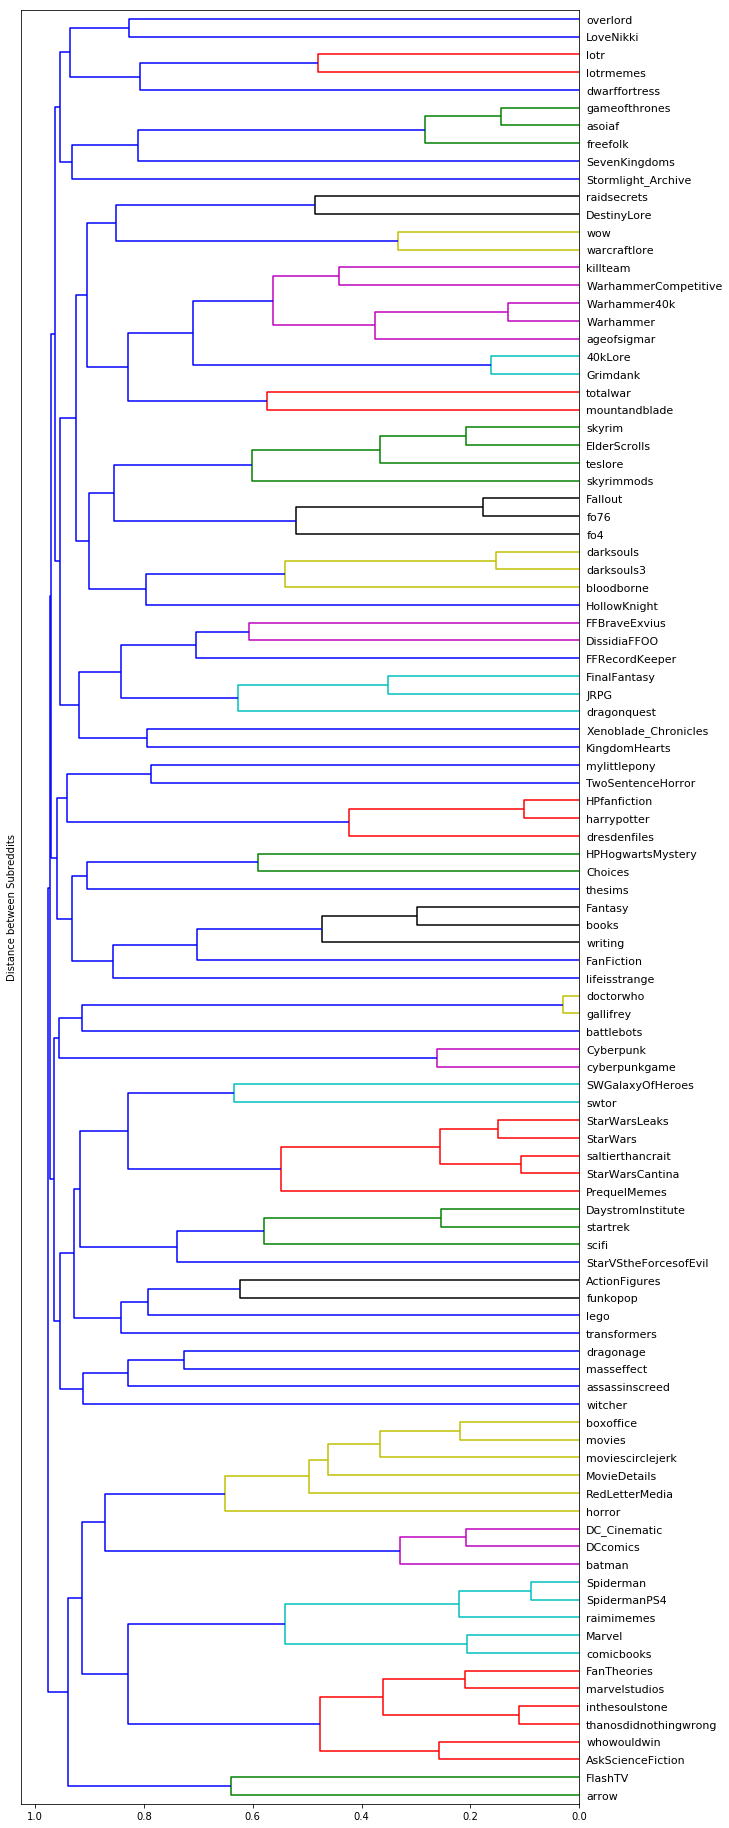


                                     Cluster 38


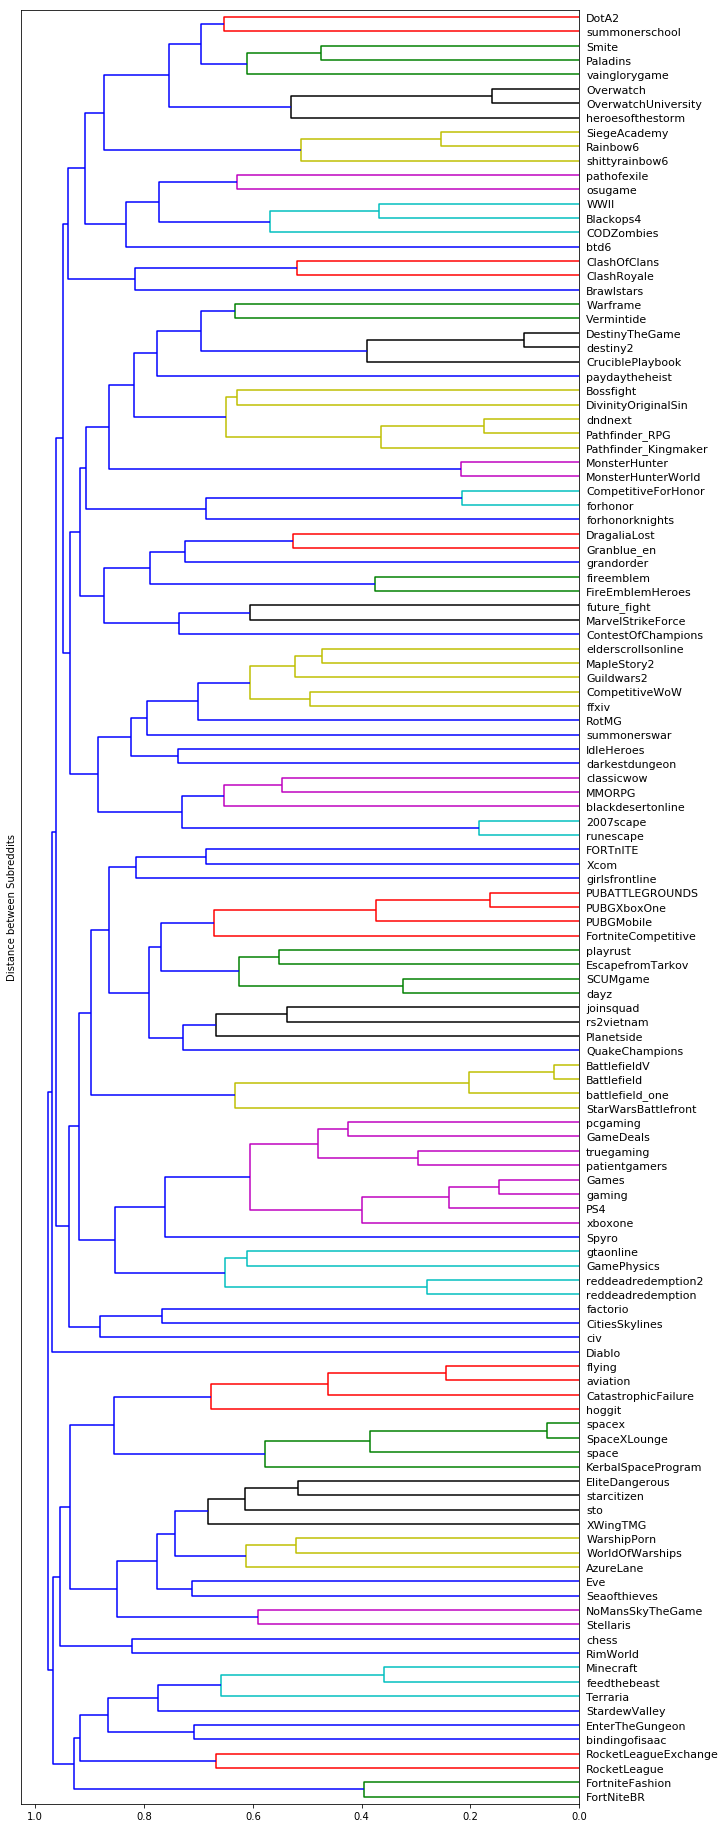


                                     Cluster 39


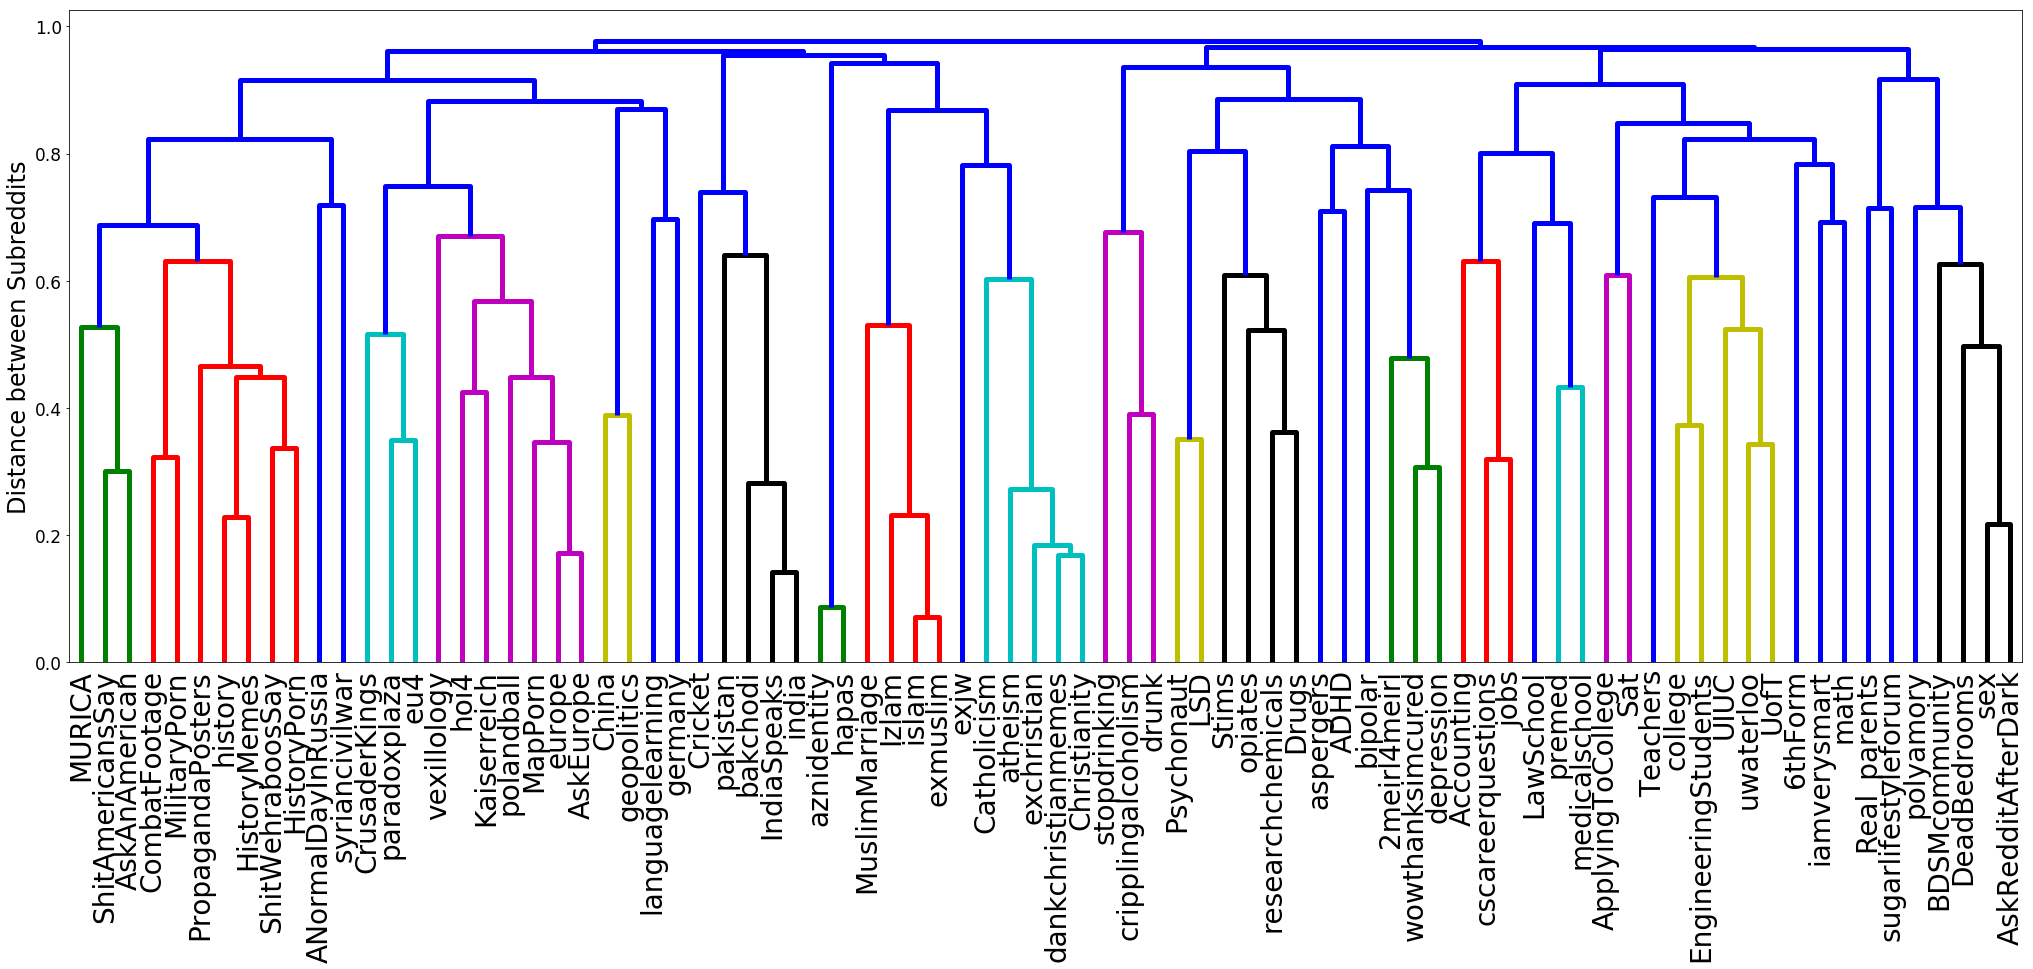


                                     Cluster 40


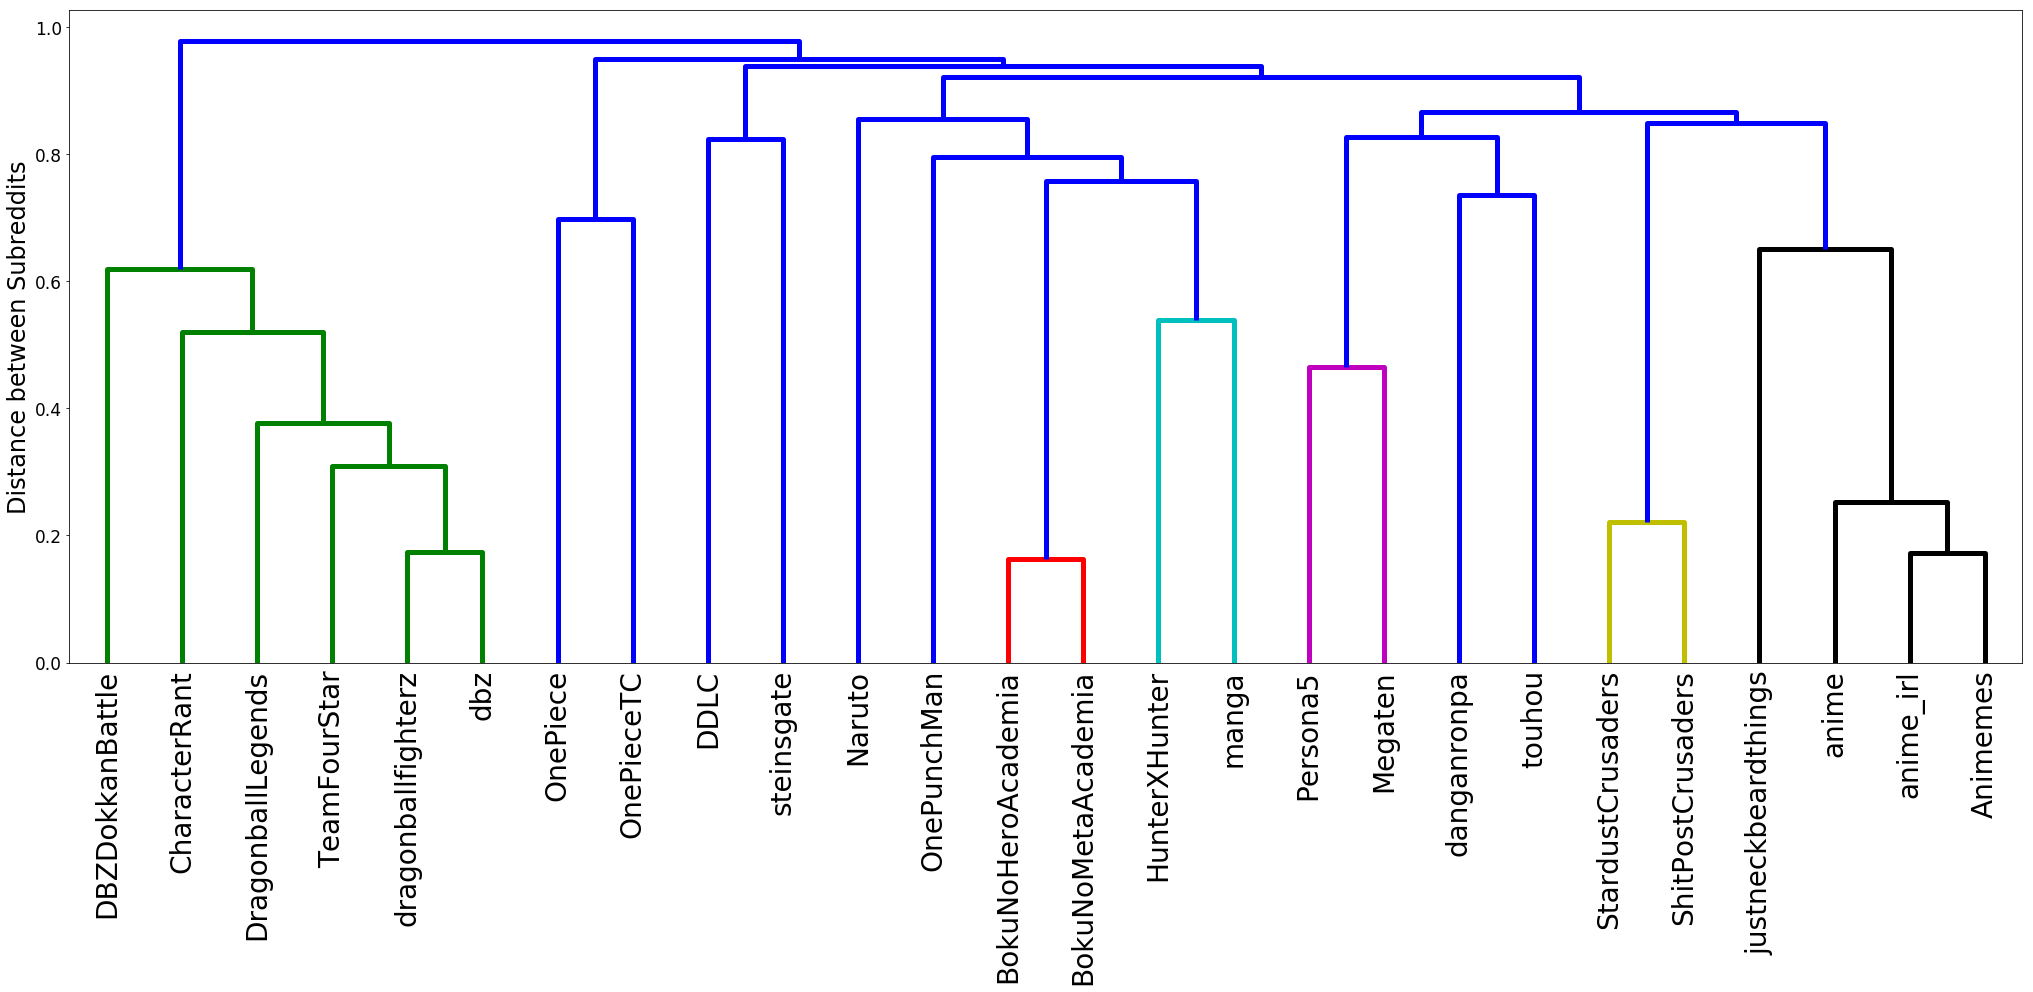

In [25]:
# prints N dendrograms (one per Cluster)

subreddit_groupsXvocwords = np.zeros([N, 15000-stop_words])

counter=1
subreddits_groups = []
for t in m:
    if t!=[]:
        print('\n                                     Cluster '+str(counter) 
#               + ' with '+ str(len(t)) +' subreddits'
             )
#         for s in t:
#             print(labels_dict[s], end =', ')
#     if counter == 20 or counter == 24 or counter == 40 :
        if len(t) > 1 :
            matrix = np.zeros([len(t),15000-stop_words])
            matrix_labels = []
            for n, s in enumerate(t):
                matrix_labels.append(labels_dict[s])
                matrix[n,:] += subreddit_tf_idf[s,:]
            sub_z = hac.linkage(matrix, method = 'complete', metric = 'cosine')

#             mpl.rcParams['axes.titlesize'] = 60

            if len(t)<10:
                plt.figure(figsize=(2*len(t)+3, len(t)))
                plt.rc_context({'lines.linewidth': 2})
                hac.dendrogram(sub_z, labels = matrix_labels)
                ax = plt.gca()
                ax.tick_params(axis='x', which='major', labelsize=13)
                ax.tick_params(axis='y', which='major', labelsize=7)
#                 plt.title('Hierarchical Clustering Dendrogram of Cluster '+ str(counter), fontsize = 25)
    #             plt.xlabel('Subreddits')
                plt.ylabel('Distance between Subreddits')

            elif len(t)>100:
                plt.figure(figsize=(10, 33))
                hac.dendrogram(sub_z, labels = matrix_labels, orientation = 'left')
                ax = plt.gca()
                ax.tick_params(axis='x', which='major', labelsize=10)
                ax.tick_params(axis='y', which='major', labelsize=11)
#                 plt.title('Hierarchical Clustering Dendrogram of Cluster '+ str(counter), fontsize = 25)
    #             plt.xlabel('Subreddits')
                plt.ylabel('Distance between Subreddits')



            else:
                plt.figure(figsize=(35, 12))
#                 if len(t)>=10 and len(t)<30:   
#                     hac.dendrogram(sub_z, labels = matrix_labels, leaf_rotation=45.)
#                 else:
                with plt.rc_context({'lines.linewidth': 5}):
                    hac.dendrogram(sub_z, labels = matrix_labels, leaf_rotation=90.)
                ax = plt.gca()
                ax.tick_params(axis='x', which='major', labelsize=28)
                ax.tick_params(axis='y', which='major', labelsize=17)
#                 plt.title('Hierarchical Clustering Dendrogram of Cluster '+ str(counter), fontsize = 25)
#                 plt.xlabel('Subreddits')
                plt.ylabel('Distance between Subreddits', fontsize = 24)

            plt.show()

            subreddits_groups.append('Cluster '+str(counter))
        else:
            subreddits_groups.append(t)
        counter+=1               

In [10]:
subreddit_groupsXvocwords = np.zeros([N, 15000-stop_words])

counter=0
subreddits_groups = []
for t in m:
    if t!=[]:
        for s in t:
            subreddit_groupsXvocwords[counter,:] += count_matrix_small[s,:]
        counter+=1

In [12]:
hac_tfidf = tfidf(subreddit_groupsXvocwords)
normalized_hac = np.zeros([N, 15000 - stop_words])

for i in range(15000 - stop_words):
    normalized_hac[:,i] += hac_tfidf[:,i]/sum(hac_tfidf[:,i])
    
# for i in range(15000 - stop_words):
#     print(max(normalized_hac[:,i]))

In [13]:
HAC_matrix= np.zeros([15003,40])

with open('vocab.bpe.from','r') as f:
    keys = f.read().splitlines()
    for i, key in enumerate(keys):
        if key in voc_dict_inv_clean.keys():
            HAC_matrix[i,:] += normalized_hac[:,voc_dict_inv_clean[key]]

In [14]:
with open('HAC_vectors.pickle', 'wb') as h:
    pickle.dump(HAC_matrix, h)